# Diamonds 데이터 분석 캡스톤  -- 데이터 전처리 심화

본 과제는 Kaggle의 Diamonds 데이터셋을 활용하여 데이터 전처리부터 탐색적 데이터 분석, 통계적 추론, 회귀분석까지 데이터 분석의 전체 흐름을 경험하는 것을 목표로 하는 평가 과제 입니다.



아래 미션들은 “정답을 맞히는 과제”가 아니라, 데이터를 통해 하나의 이야기를 만들어 가는 탐구 과제입니다.



각 미션은 서로 독립적이지만, 모두 합치면 하나의 질문으로 수렴합니다.

#### 패키지 가져오기

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind,mannwhitneyu
import pingouin as pg
from math import sqrt

# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statannotations.Annotator import Annotator


# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell


import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr


from sklearn.preprocessing import RobustScaler

#### 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 데이터 불러오기

In [3]:
origin = load_data('diamonds')

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)



### 미션 1. 이 데이터는 얼마나 믿을 수 있을까?


1. 데이터 테이블 셋을 전반적으로 확인하면서 이상치/결측치 판단
   - 데이터는 모두 non-null 로 확인되었다
   - x,y,z 값은 다이아몬드의 가로/세로/높이 길이를 나타내는 값으로 0 이 존재할 수 없으나, 0인 값들이 발견되었다
   - 해당 결측치들은 특정 color, cut,clarity 에서만 발생한 것이 아닌 전체적으로 무작위로 발생해 MCAR 결측치로 판단하였고, 또 그 수가 전체 데이터의 1% 미만으로 확인되어 행 전체를 단순 제거로 처리하였다.
    (*값이 0인 경우 : x 는 8개 / y 는 7개 / z 는 20개)
   - Boxplot 을 그렸을 때의 추가적으로 소수의 이상치를 확인한 후, y 가 30을 넘는 경우, z 가 30을 넘는 경우도 행 전체를 단순 제거로 처리하였다.(이 역시 데이터수가 적어 전체 데이터에 대한 영향력이 작을 것이라 판단)
  
2. 각 데이터들의 범주 구성과 특징을 확인  
   - cut의 종류 5가지 : ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
   - 상단 리스트 내 cut 종류 순서대로 각 차지 비중이 40% ,26% ,9% ,22% 3% 로 확인되었다. Ideal 의 차지비중이 40% 가장 높고 Fair 는 3%로 종류 간의 비중 차이가 존재한다.

   - color 의 종류 7가지 : ['E' 'I' 'J' 'H' 'F' 'G' 'D']
   - 상단 리스트 내 color 의 종류 순서대로 각 차지 비중이 18%,10%,5%,15%,18%,21%,13% 로 확인되었다. 전체적으로 10-20%로 고르게 분포하지만, J 의 경우 10% 대 미만인 5%로 타 색상에 비해 비중이 낮다.
  
   - clarity 의 종류 8가지 : ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
   - 상단 리스트 내 clarity 의 종류 순서대로 각 차지 비중이 17%,24%,15%,23%,9%,7%,1%,3% 로 확인되었다.SI1 과 SI2 를 합지만 약 41%, VS1과 VS2를 합지면 약 38% 로 대부분을 차지하였고, 가장 희귀한 등급인 IF 는 3% 로 등급간의 비중 차이가 존재한다.

3. 데이터 전처리 전/후 변화 확인
   - 결측치 단순 제거 후에도 Boxplot 에서 이상치들이 다수 확인되고 있지만, 단순 제거로 모두 처리하기엔 다수라 판단하여 이후 분석을 이어서 진행하였다.
  

In [4]:
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   color    53940 non-null  object 
 4   clarity  53940 non-null  object 
 5   x        53940 non-null  float64
 6   y        53940 non-null  float64
 7   z        53940 non-null  float64
 8   depth    53940 non-null  float64
 9   table    53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


- 캐럿 당 다이아몬드 가격 파생 변수 추가

In [5]:
origin2=origin.copy()
origin2["ppc"] = origin2["price"] / origin2["carat"]


> 범주형 변수들의 구성을 확인하고 서열 척도로 변환

In [6]:
print('cut의 종류' , origin['cut'].unique())
print('color 의 종류', origin['color'].unique())
print('clarity 의 종류', origin['clarity'].unique())

cut의 종류 ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color 의 종류 ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity 의 종류 ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [7]:
컬럼타입변경df = origin2.copy()

#clarity
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
clarity_type = CategoricalDtype(categories=clarity_order, ordered=True)

컬럼타입변경df['clarity'] = 컬럼타입변경df['clarity'].astype(clarity_type)

#color
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
color_type = CategoricalDtype(categories=color_order, ordered=True)

컬럼타입변경df['color'] = 컬럼타입변경df['color'].astype(color_type)

#cut
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
cut_type = CategoricalDtype(categories=cut_order, ordered=True)

컬럼타입변경df['cut'] = 컬럼타입변경df['cut'].astype(cut_type)



In [8]:
#데이터 변환 확인 완료

컬럼타입변경df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53940 non-null  int64   
 1   carat    53940 non-null  float64 
 2   cut      53940 non-null  category
 3   color    53940 non-null  category
 4   clarity  53940 non-null  category
 5   x        53940 non-null  float64 
 6   y        53940 non-null  float64 
 7   z        53940 non-null  float64 
 8   depth    53940 non-null  float64 
 9   table    53940 non-null  float64 
 10  ppc      53940 non-null  float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 3.4 MB


In [9]:
파생변수생성df = 컬럼타입변경df.copy()

color_gia_map = {
    'D': 'Colorless',
    'E': 'Colorless',
    'F': 'Colorless',
    'G': 'Near_Colorless',
    'H': 'Near_Colorless',
    'I': 'Near_Colorless',
    'J': 'Near_Colorless'
}

파생변수생성df['color_gia'] = 파생변수생성df['color'].map(color_gia_map)



clarity_gia_map = {
    'IF': 'Internally_Flawless',
    'VVS1': 'VVS',
    'VVS2': 'VVS',
    'VS1': 'VS',
    'VS2': 'VS',
    'SI1': 'SI',
    'SI2': 'SI',
    'I1': 'I'
}

파생변수생성df['clarity_gia'] = 파생변수생성df['clarity'].map(clarity_gia_map)


파생변수생성df


,price,carat,cut,color,clarity,x,y,z,depth,table,ppc,color_gia,clarity_gia
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,1417.391304,Colorless,SI
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,1552.380952,Colorless,SI
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,1421.739130,Colorless,VS
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,1151.724138,Near_Colorless,VS
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,1080.645161,Near_Colorless,SI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0,3829.166667,Colorless,SI
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0,3829.166667,Colorless,SI
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0,3938.571429,Colorless,SI
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0,3205.813953,Near_Colorless,SI


In [10]:
파생변수생성_타입변환df=파생변수생성df.copy()

# color_gia 순서 정의
color_gia_order = ['Near_Colorless', 'Colorless']
color_gia_type = CategoricalDtype(categories=color_gia_order, ordered=True)

# clarity_gia 순서 정의
clarity_gia_order = [
    'I',
    'SI',
    'VS',
    'VVS',
    'Internally_Flawless'
]

clarity_gia_type = CategoricalDtype(
    categories=clarity_gia_order,
    ordered=True
)

# 타입 변환
파생변수생성_타입변환df['clarity_gia'] = 파생변수생성_타입변환df['clarity_gia'].astype(clarity_gia_type)



# 타입 변환
파생변수생성_타입변환df['color_gia'] = 파생변수생성_타입변환df['color_gia'].astype(color_gia_type)


In [11]:
파생변수생성_타입변환df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   price        53940 non-null  int64   
 1   carat        53940 non-null  float64 
 2   cut          53940 non-null  category
 3   color        53940 non-null  category
 4   clarity      53940 non-null  category
 5   x            53940 non-null  float64 
 6   y            53940 non-null  float64 
 7   z            53940 non-null  float64 
 8   depth        53940 non-null  float64 
 9   table        53940 non-null  float64 
 10  ppc          53940 non-null  float64 
 11  color_gia    53940 non-null  category
 12  clarity_gia  53940 non-null  category
dtypes: category(5), float64(7), int64(1)
memory usage: 3.6 MB


In [12]:
컬럼타입변경df=파생변수생성_타입변환df.copy()

컬럼타입변경df = 컬럼타입변경df.drop(columns=['color', 'clarity'])

컬럼타입변경df = 컬럼타입변경df.rename(columns={
    'color_gia': 'color',
    'clarity_gia': 'clarity'
})



In [13]:
컬럼타입변경df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53940 non-null  int64   
 1   carat    53940 non-null  float64 
 2   cut      53940 non-null  category
 3   x        53940 non-null  float64 
 4   y        53940 non-null  float64 
 5   z        53940 non-null  float64 
 6   depth    53940 non-null  float64 
 7   table    53940 non-null  float64 
 8   ppc      53940 non-null  float64 
 9   color    53940 non-null  category
 10  clarity  53940 non-null  category
dtypes: category(3), float64(7), int64(1)
memory usage: 3.4 MB


> 데이터를 확인해보니, 모든 컬럼에서 null 은 확인되지 않음
> object 데이터들은 category (서열) 로 타입을 변경

> 각 범주형 변수의 차지 비중 확인

<cut 의 경우>

In [14]:
cut_list = 컬럼타입변경df['cut'].unique()

cut_counts = []

for cut in cut_list:
    count = len(컬럼타입변경df.query('cut == @cut'))
    cut_counts.append(count)

# 데이터프레임 생성
cut_df = pd.DataFrame({
    'cut': cut_list,
    'count': cut_counts
})

# 전체 개수
total = cut_df['count'].sum()

# 비율 추가
cut_df['ratio'] = cut_df['count'] / total
cut_df['percent'] = cut_df['ratio'] * 100

cut_df


,cut,count,ratio,percent
0,Ideal,21551,0.399537,39.953652
1,Premium,13791,0.255673,25.567297
2,Good,4906,0.090953,9.095291
3,Very Good,12082,0.223990,22.398962
4,Fair,1610,0.029848,2.984798


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\4094096883.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


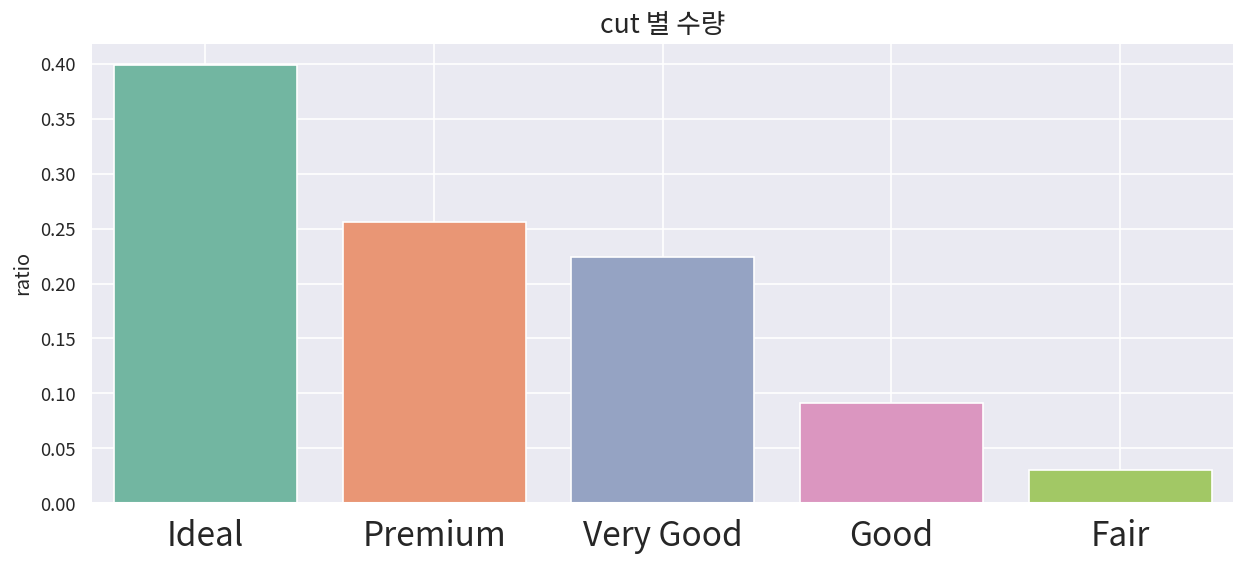

In [15]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=cut_df,           #사용할 데이터 프레임
    x='cut',        #막대의 카테고리축
    y='ratio',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('cut 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<color 의 경우>

In [16]:
color_list = 컬럼타입변경df['color'].unique()

color_counts = []   # 개수 저장 리스트

for color in color_list:
    count = len(컬럼타입변경df.query('color == @color'))
    color_counts.append(count)

# 데이터프레임 생성
color_df = pd.DataFrame({
    'color': color_list,
    'count': color_counts
})

# 전체 개수
total = color_df['count'].sum()

# 비율 추가
color_df['ratio'] = color_df['count'] / total
color_df['percent'] = (color_df['ratio'] * 100).round(2)

color_df
    


,color,count,ratio,percent
0,Colorless,26114,0.484131,48.41
1,Near_Colorless,27826,0.515869,51.59


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\1751062025.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


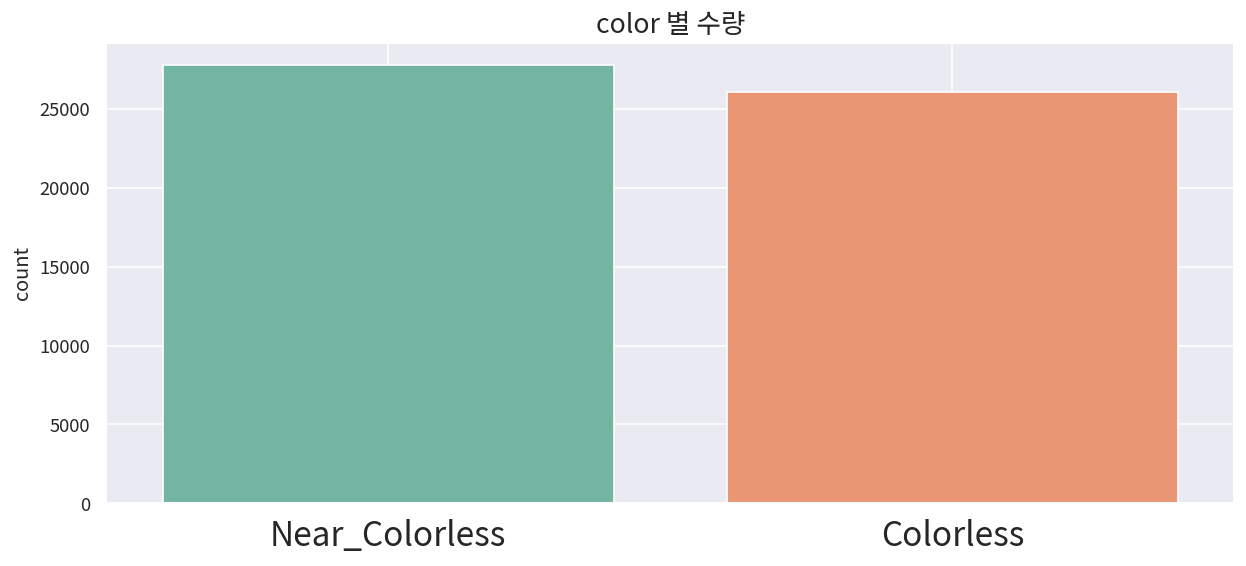

In [17]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=color_df,           #사용할 데이터 프레임
    x='color',        #막대의 카테고리축
    y='count',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('color 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<clarity 의 경우>

In [18]:
clarity_list = 컬럼타입변경df['clarity'].unique()

clarity_counts = []   # 개수 저장 리스트

for clarity in clarity_list:
    count = len(컬럼타입변경df.query('clarity == @clarity'))
    clarity_counts.append(count)

# 데이터프레임 생성
clarity_df = pd.DataFrame({
    'clarity': clarity_list,
    'count': clarity_counts
})

# 전체 개수
total = clarity_df['count'].sum()

# 비율 추가
clarity_df['ratio'] = clarity_df['count'] / total
clarity_df['percent'] = (clarity_df['ratio'] * 100).round(2)

clarity_df


,clarity,count,ratio,percent
0,SI,22259,0.412662,41.27
1,VS,20429,0.378736,37.87
2,VVS,8721,0.161680,16.17
3,I,741,0.013737,1.37
4,Internally_Flawless,1790,0.033185,3.32


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\3701971750.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


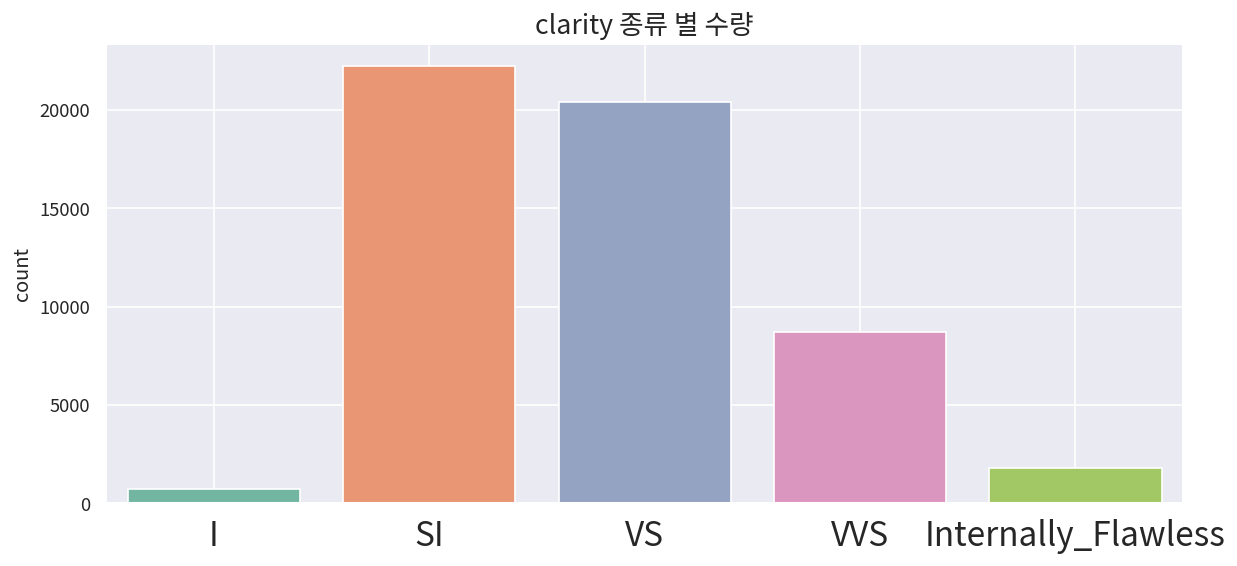

In [19]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=clarity_df,           #사용할 데이터 프레임
    x='clarity',        #막대의 카테고리축
    y='count',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('clarity 종류 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


> 데이터 전처리 전의 전반적인 데이터 현황 파악을 위한 boxplot

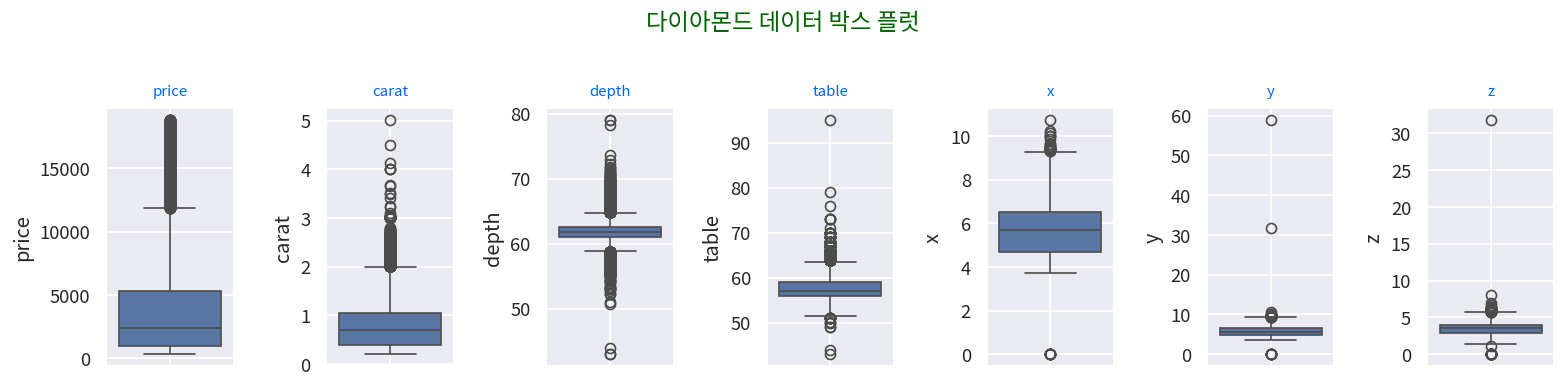

In [20]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 크기 늘림
height_px = 400              # 세로 크기 줄임 (1행)
rows = 1
cols = 7
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) boxplot 그리기
sb.boxplot(data=컬럼타입변경df, y='price', ax=ax[0])
sb.boxplot(data=컬럼타입변경df, y='carat', ax=ax[1])   # ✅ carat 추가
sb.boxplot(data=컬럼타입변경df, y='depth', ax=ax[2])
sb.boxplot(data=컬럼타입변경df, y='table', ax=ax[3])
sb.boxplot(data=컬럼타입변경df, y='x', ax=ax[4])
sb.boxplot(data=컬럼타입변경df, y='y', ax=ax[5])
sb.boxplot(data=컬럼타입변경df, y='z', ax=ax[6])

# 3) 그래프 꾸미기
fig.suptitle('다이아몬드 데이터 박스 플럿', fontsize=14, color='#006600')

fig.subplots_adjust(wspace=0.3)

titles = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

for i in range(7):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


> 0이 있는 행을 찾아 전처리 진행

In [21]:
컬럼타입변경df.eq(0).sum()


price       0
carat       0
cut         0
x           8
y           7
z          20
depth       0
table       0
ppc         0
color       0
clarity     0
dtype: int64

In [22]:
zero_rows = 컬럼타입변경df[컬럼타입변경df.eq(0).any(axis=1)]
zero_columns = 컬럼타입변경df.eq(0).any()

zero_rows, zero_columns


(       price  carat        cut     x     y    z  depth  table           ppc  \
 2207    3142   1.00    Premium  6.55  6.48  0.0   59.1   59.0   3142.000000   
 2314    3167   1.01    Premium  6.66  6.60  0.0   58.1   59.0   3135.643564   
 4791    3696   1.10    Premium  6.50  6.47  0.0   63.0   59.0   3360.000000   
 5471    3837   1.01    Premium  6.50  6.47  0.0   59.2   58.0   3799.009901   
 10167   4731   1.50       Good  7.15  7.04  0.0   64.0   61.0   3154.000000   
 11182   4954   1.07      Ideal  0.00  6.62  0.0   61.6   56.0   4629.906542   
 11963   5139   1.00  Very Good  0.00  0.00  0.0   63.3   53.0   5139.000000   
 13601   5564   1.15      Ideal  6.88  6.83  0.0   59.2   56.0   4838.260870   
 15951   6381   1.14       Fair  0.00  0.00  0.0   57.5   67.0   5597.368421   
 24394  12631   2.18    Premium  8.49  8.45  0.0   59.4   61.0   5794.036697   
 24520  12800   1.56      Ideal  0.00  0.00  0.0   62.2   54.0   8205.128205   
 26123  15397   2.25    Premium  8.52  8

> 특정 colore, cut, clarity 에서만 결측치가 발생한 것이 아닌 랜덤으로 발생했다고 판단, 또한 크기가 0 인 경우가 전체의 0.03% 로 단순 제거해도 영향력은 크지 않을 것이라고 판단하여 단순 제거 선택

<이상치 (x,y,z 중 하나라도 0이 있는 경우) drop 결정>

In [23]:
df_clean = 컬럼타입변경df[(컬럼타입변경df[['x','y','z']] != 0).all(axis=1)]
df_clean

,price,carat,cut,x,y,z,depth,table,ppc,color,clarity
0,326,0.23,Ideal,3.95,3.98,2.43,61.5,55.0,1417.391304,Colorless,SI
1,326,0.21,Premium,3.89,3.84,2.31,59.8,61.0,1552.380952,Colorless,SI
2,327,0.23,Good,4.05,4.07,2.31,56.9,65.0,1421.739130,Colorless,VS
3,334,0.29,Premium,4.20,4.23,2.63,62.4,58.0,1151.724138,Near_Colorless,VS
4,335,0.31,Good,4.34,4.35,2.75,63.3,58.0,1080.645161,Near_Colorless,SI
...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,5.75,5.76,3.50,60.8,57.0,3829.166667,Colorless,SI
53936,2757,0.72,Good,5.69,5.75,3.61,63.1,55.0,3829.166667,Colorless,SI
53937,2757,0.70,Very Good,5.66,5.68,3.56,62.8,60.0,3938.571429,Colorless,SI
53938,2757,0.86,Premium,6.15,6.12,3.74,61.0,58.0,3205.813953,Near_Colorless,SI


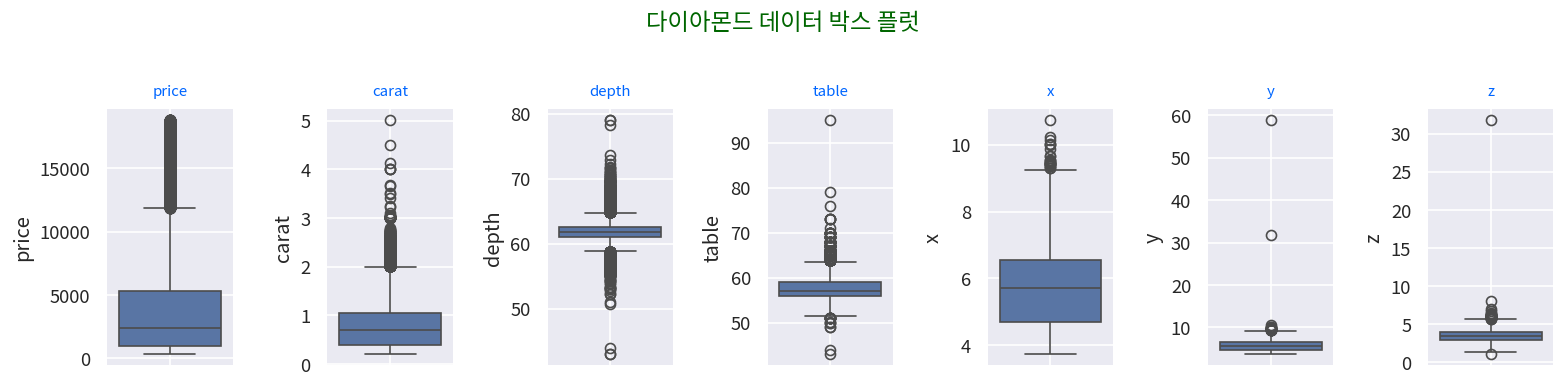

In [24]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 넉넉하게
height_px = 400              # 1행이므로 세로 축소
rows = 1
cols = 7
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_clean, y='price', ax=ax[0])
sb.boxplot(data=df_clean, y='carat', ax=ax[1])   # ✅ 추가
sb.boxplot(data=df_clean, y='depth', ax=ax[2])
sb.boxplot(data=df_clean, y='table', ax=ax[3])
sb.boxplot(data=df_clean, y='x', ax=ax[4])
sb.boxplot(data=df_clean, y='y', ax=ax[5])
sb.boxplot(data=df_clean, y='z', ax=ax[6])

# 3) 그래프 꾸미기
fig.suptitle('다이아몬드 데이터 박스 플럿', fontsize=14, color='#006600')
fig.subplots_adjust(wspace=0.3)

titles = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

for i in range(7):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


> x,y,z 중 0이 있는 값을 제거한 후의 박스 플럿
> 전체 데이터를 기준으로 조회하면 여전히 이상치들이 다수 확인되었음
> 특히 y 와 z 에서 특정 이상치가 두드러지게 확인되었음 (y, z 가 30이 넘는 경우도 제거 결정)

In [25]:
df_clean2 = df_clean.copy()
df_clean2 = df_clean2[(df_clean2['y'] <= 30) & (df_clean2['z'] <= 30)]
df_clean2.head()

,price,carat,cut,x,y,z,depth,table,ppc,color,clarity
0,326,0.23,Ideal,3.95,3.98,2.43,61.5,55.0,1417.391304,Colorless,SI
1,326,0.21,Premium,3.89,3.84,2.31,59.8,61.0,1552.380952,Colorless,SI
2,327,0.23,Good,4.05,4.07,2.31,56.9,65.0,1421.739130,Colorless,VS
3,334,0.29,Premium,4.20,4.23,2.63,62.4,58.0,1151.724138,Near_Colorless,VS
4,335,0.31,Good,4.34,4.35,2.75,63.3,58.0,1080.645161,Near_Colorless,SI


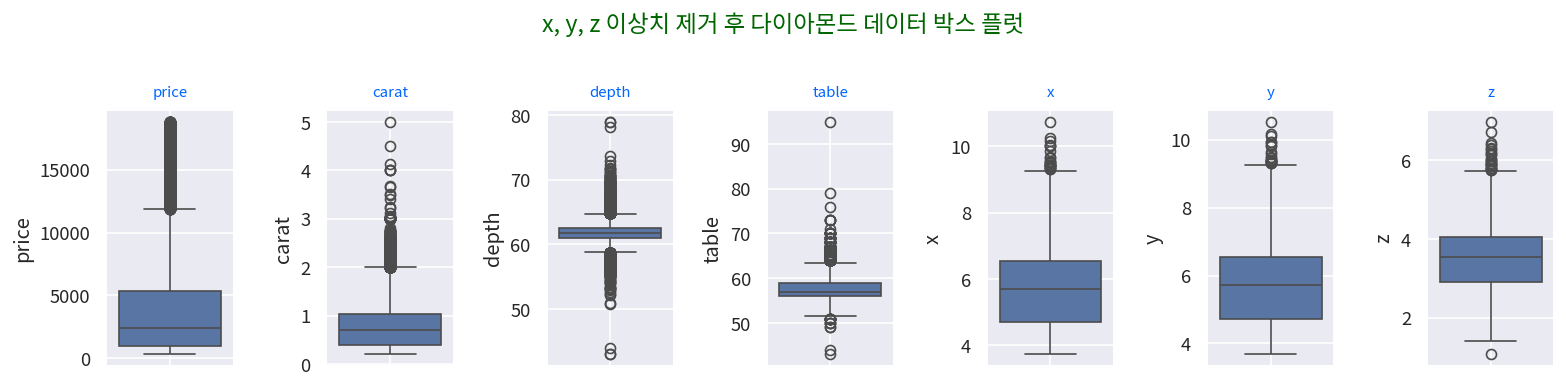

In [26]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 넉넉하게
height_px = 400              # 1행이므로 세로 축소
rows = 1
cols = 7
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_clean2, y='price', ax=ax[0])
sb.boxplot(data=df_clean2, y='carat', ax=ax[1])   # ✅ carat 추가
sb.boxplot(data=df_clean2, y='depth', ax=ax[2])
sb.boxplot(data=df_clean2, y='table', ax=ax[3])
sb.boxplot(data=df_clean2, y='x', ax=ax[4])
sb.boxplot(data=df_clean2, y='y', ax=ax[5])
sb.boxplot(data=df_clean2, y='z', ax=ax[6])

# 3) 그래프 꾸미기
fig.suptitle(
    'x, y, z 이상치 제거 후 다이아몬드 데이터 박스 플럿',
    fontsize=14,
    color='#006600'
)

fig.subplots_adjust(wspace=0.3)

titles = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

for i in range(7):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


### .RobustScaler
- 이상치가 존재할 경우 이상치의 영향을 최소화 하여 데이터를 스케일링 하는 방법
- 이상치가 포함된 데이터를 표준화 혹은 정규화를 할 떄 이상치의 영향으로 전체 데이터의 분포가 왜곡될 수 있음
- RobustScaler 는 이 문제를 해결하기 위해 중앙값과 사분위수를 사용하여 데이터를 스케일링 함

> x,y,z,depth,table 등 다이아몬드의 길이 측정과 관련된 값들 robustScaler 로 스케일링

In [27]:

df_clean3 = df_clean2.copy()
scaler = RobustScaler()
cols_to_scale = ['x', 'y', 'z', 'depth', 'table']
df_clean3[cols_to_scale] = scaler.fit_transform(df_clean3[cols_to_scale])


In [28]:
df_clean3

,price,carat,cut,x,y,z,depth,table,ppc,color,clarity
0,326,0.23,Ideal,-0.956284,-0.950549,-0.973451,-0.200000,-0.666667,1417.391304,Colorless,SI
1,326,0.21,Premium,-0.989071,-1.027473,-1.079646,-1.333333,1.333333,1552.380952,Colorless,SI
2,327,0.23,Good,-0.901639,-0.901099,-1.079646,-3.266667,2.666667,1421.739130,Colorless,VS
3,334,0.29,Premium,-0.819672,-0.813187,-0.796460,0.400000,0.333333,1151.724138,Near_Colorless,VS
4,335,0.31,Good,-0.743169,-0.747253,-0.690265,1.000000,0.333333,1080.645161,Near_Colorless,SI
...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,0.027322,0.027473,-0.026549,-0.666667,0.000000,3829.166667,Colorless,SI
53936,2757,0.72,Good,-0.005464,0.021978,0.070796,0.866667,-0.666667,3829.166667,Colorless,SI
53937,2757,0.70,Very Good,-0.021858,-0.016484,0.026549,0.666667,1.000000,3938.571429,Colorless,SI
53938,2757,0.86,Premium,0.245902,0.225275,0.185841,-0.533333,0.333333,3205.813953,Near_Colorless,SI


### 미션 2 가격 데이터는 어떤 모습일까

1. price 변수 분포 확인
   - 낮은 가격대(약 500 ~ 2,000) 구간에 데이터가 집중되어 있다.
   - 가격이 높아질수록 관측치가 급격히 줄어들며,
   - 오른쪽으로 긴 꼬리를 가진 분포(right-skewed) 형태를 보인다.
   - 10,000 이상 고가 구간은 극히 소수로, 이상치(outlier) 성격을 띤다.
   - 다수의 저가 항목과 소수의 고가 항목이 있는 비대칭적인 분포를 띤다.
  
2. carat 변수 분포 확인
   - 0.2 ~ 1.0 캐럿 구간에 관측치가 매우 많이 몰려 있다.
   - 1 캐럿 이상부터는 빈도가 급격히 감소하며,3~5 캐럿 구간은 극히 드물다.
   - 특정 값(0.3, 0.5, 1.0 등) 근처에서 봉우리가 여러 개 나타나는데,
    이는 실제 시장에서 선호되는 캐럿 단위가 존재하기 때문으로 해석할 수 있다.
  

3. price 와 carat 변수 공통점과 차이점 확인
   [공통점]
   - 두 변수 모두 오른쪽으로 치우친 분포
   - 대부분 낮은 값 구간에 집중되어 있고, 극단적으로 큰 이상치가 존재한다
   
   [차이점]
   - price 는 비교적 매끄러운 연속 분포 현태
   - carat 은 특정 값에 수직으로 몰린 다봉형 분포

4. 회귀분석 진행 가능 여부 확인
   > 적절하지 않다
   - 회귀분석은 잔차의 정규성을 가정하는데 현재 비대칭성은 해당 가정을 위반한다
   - 이상치가 다수 확인된다

In [29]:
df_plot = df_clean3.copy()

> price per carat 데이터 그래프 확인

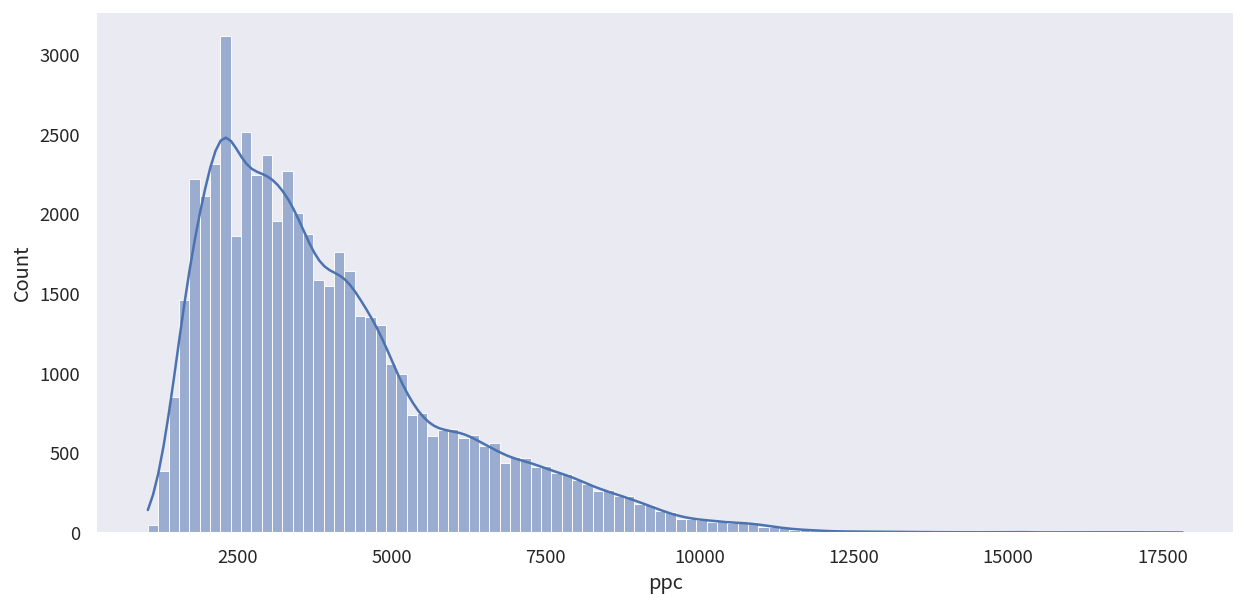

In [30]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_plot['ppc'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

> carat 데이터 분포 확인

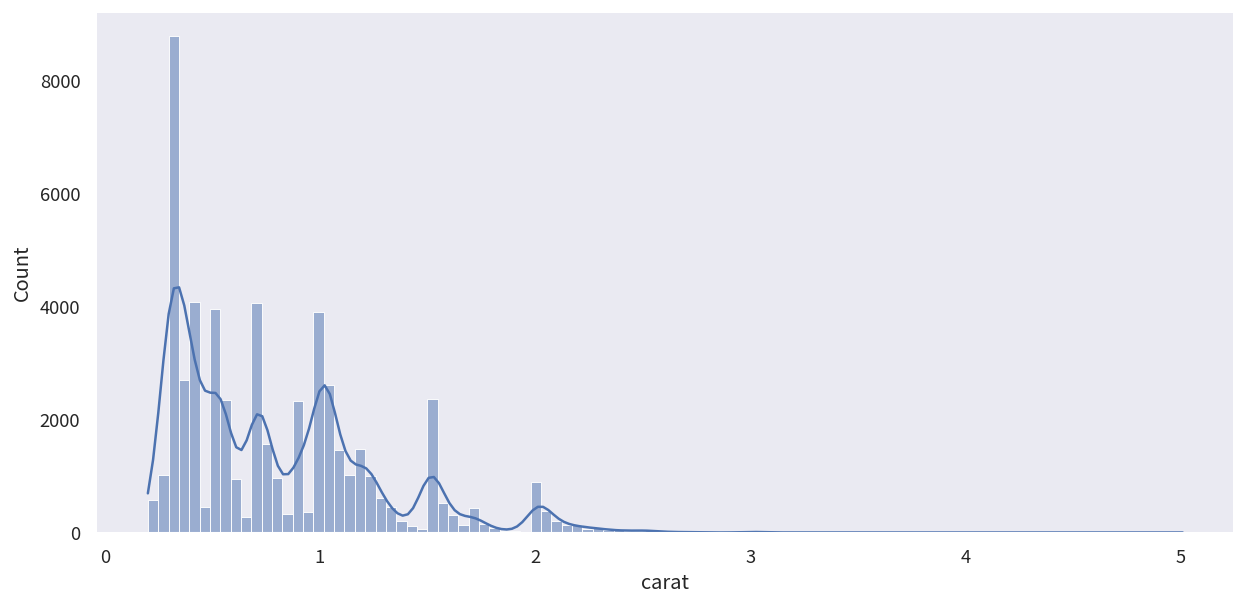

In [31]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_plot['carat'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

### 미션 3. 로그 변환은 왜 등장할까?

1. price 와 carat 변수에 로그 변환을 적용해보고, 변환 전과 후의 분포 비교
   
   [price]
   - 로그 변환 전 price 분포는 낮은 가격대에 관측치가 집중되고, 높은 가격대로 갈수록 빈도가 급격히 감소하는 강한 우측 치우침(right-skewed) 을 보인다.

   - 로그 변환 후에는 분포의 비대칭성이 완화되며,데이터가 보다 넓고 고르게 퍼진 형태로 변화하였다.특히 고가 구간의 극단값 영향이 줄어들어 분포가 더 안정적으로 보인다.

   [carat]
   - 로그 변환 전에는 작은 값에 데이터가 집중된 비대칭 분포를 가진다.
   - 로그 변환 후에는 작은 캐럿 구간이 상대적으로 확장되며,분포의 왜곡이 줄어든 모습을 확인할 수 있다.
   - 다만 carat은 로그 변환 이후에도 완전한 정규분포 형태는 나타나지 않는다.
  
2. 로그 변환을 하면 무엇이 달라지는지, 또 로그 변환의 필요성 설명
   - 로그 변환을 적용하면 큰 값은 압축되고 작은 값은 상대적으로 확대되어 극단값(outlier)의 영향이 완화된다.
   - 분포의 우측 치우침이 줄어들어 보다 대칭적인 형태에 가까워진다.
   - 변수 간 관계가 선형에 가까워져 회귀분석의 가정(정규성, 등분산성) 을 만족할 가능성이 높아진다
   
    따라서 price와 carat처럼 한쪽으로 심하게 치우친 양의 값을 가지는 변수에 대해서는 로그 변환이 분석의 안정성과 해석력을 높이는 데 효과적이다.



In [32]:
import numpy as np
df_log = df_plot.copy()

df_log['log_price'] = np.log1p(df_log['ppc'])
df_log['log_carat'] = np.log1p(df_log['carat'])


In [33]:
# log 변환한 데이터셋 확인
df_log

,price,carat,cut,x,y,z,depth,table,ppc,color,clarity,log_price,log_carat
0,326,0.23,Ideal,-0.956284,-0.950549,-0.973451,-0.200000,-0.666667,1417.391304,Colorless,SI,7.257279,0.207014
1,326,0.21,Premium,-0.989071,-1.027473,-1.079646,-1.333333,1.333333,1552.380952,Colorless,SI,7.348189,0.190620
2,327,0.23,Good,-0.901639,-0.901099,-1.079646,-3.266667,2.666667,1421.739130,Colorless,VS,7.260339,0.207014
3,334,0.29,Premium,-0.819672,-0.813187,-0.796460,0.400000,0.333333,1151.724138,Near_Colorless,VS,7.049883,0.254642
4,335,0.31,Good,-0.743169,-0.747253,-0.690265,1.000000,0.333333,1080.645161,Near_Colorless,SI,6.986238,0.270027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,0.027322,0.027473,-0.026549,-0.666667,0.000000,3829.166667,Colorless,SI,8.250664,0.542324
53936,2757,0.72,Good,-0.005464,0.021978,0.070796,0.866667,-0.666667,3829.166667,Colorless,SI,8.250664,0.542324
53937,2757,0.70,Very Good,-0.021858,-0.016484,0.026549,0.666667,1.000000,3938.571429,Colorless,SI,8.278827,0.530628
53938,2757,0.86,Premium,0.245902,0.225275,0.185841,-0.533333,0.333333,3205.813953,Near_Colorless,SI,8.073033,0.620576


> log 변환 전/후의 price의 분포

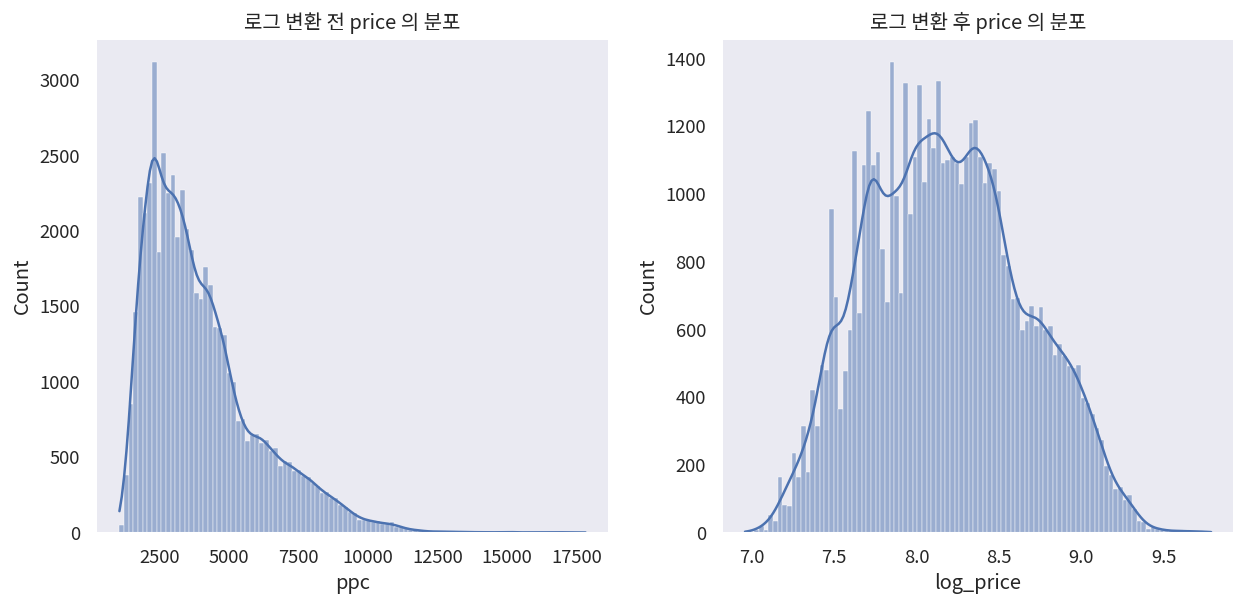

In [34]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=2                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_plot['ppc'],bins=100, kde = True,ax=ax[0])
sb.histplot(data=df_log['log_price'],bins=100, kde = True,ax=ax[1])

ax[0].set_title('로그 변환 전 price 의 분포')
ax[1].set_title('로그 변환 후 price 의 분포')

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

> log 변환 전/후의 carat 분포

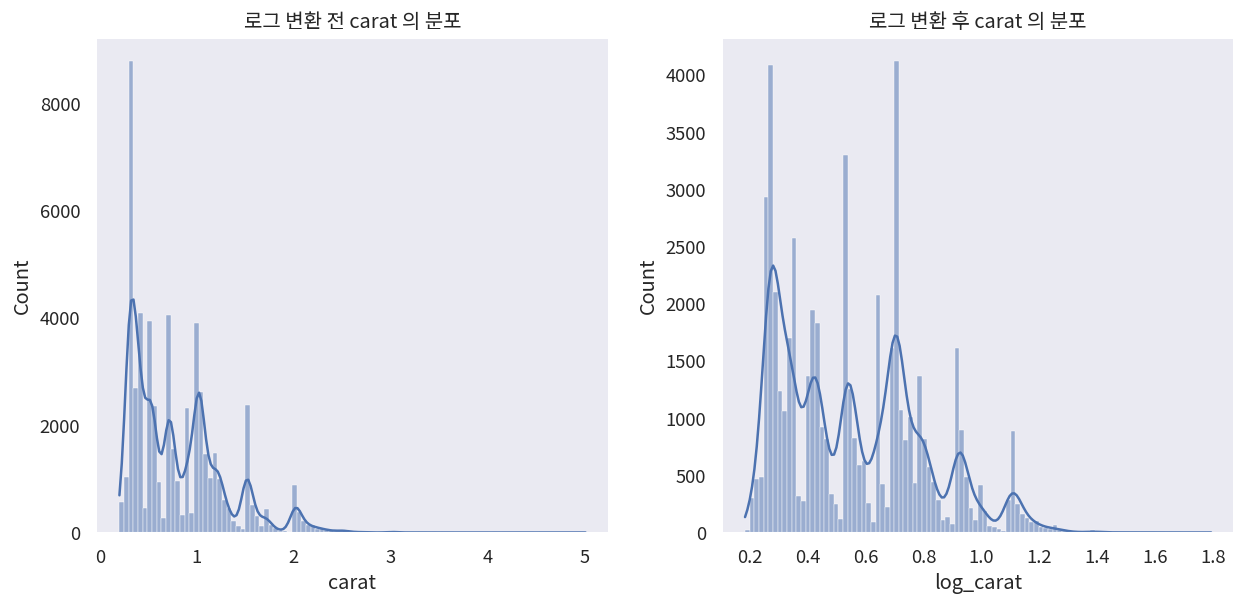

In [35]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=2                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_plot['carat'],bins=100, kde = True,ax=ax[0])
sb.histplot(data=df_log['log_carat'],bins=100, kde = True,ax=ax[1])

ax[0].set_title('로그 변환 전 carat 의 분포')
ax[1].set_title('로그 변환 후 carat 의 분포')

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

### 미션 4. 품질 등급은 가격을 얼마나 설명해줄까?

1. cut, color, clarity에 따라 다이아몬드 가격 분포가 어떻게 달라지는지 시각화 진행
   - 각 품질 변수별로 로그 변환된 가격(log_price)의 분포를 박스플롯으로 비교하였다. 중앙값(median), 사분위 범위(IQR), 이상치(outlier)를 중심으로 가격 차이를 관찰하였다.
  
2. 중앙값, 분산, 분포의 겹침 정도를 관찰하며 아래의 질문에 답해보기
   1. 어떤 품질 변수는 가격 차이가 뚜렷한가?
      - color와 clarity 변수가 cut에 비해 그룹 간 가격 차이가 비교적 뚜렷하게 관찰된다
      - color의 경우, 단변량 기준에서는 D → J 등급으로 갈수록 가격의 중앙값이 점진적으로 증가하는 경향이 나타난다.
      - clarity 의 경우 중앙값이 IF → I1 방향으로 대체적으로 증가하는 추이가 관찰된다
      - clarity의 중간 등급(VVS1, VVS2, VS1, VS2)은 서로 가격 분포가 크게 겹쳐 구분이 어렵다.


   2. 어떤 경우에는 등급이 달라도 가격이 크게 겹치는가? 
     - color 변수에서 인접한 등급 간 가격 분포의 겹침이 매우 크게 나타난다.예를 들어 D–E, E–F, G–H 등 인접 등급들은 중앙값 차이가 크지 않고,사분위 범위(IQR)가 서로 겹치는 것으로 관찰된다.
     - cut과 clarity 역시 대부분의 등급 구간에서 가격 분포가 상당 부분 겹치는 것으로 관찰된다


> cut, color, clarity에 따른 다이아몬드 가격 분포 시각화 진행

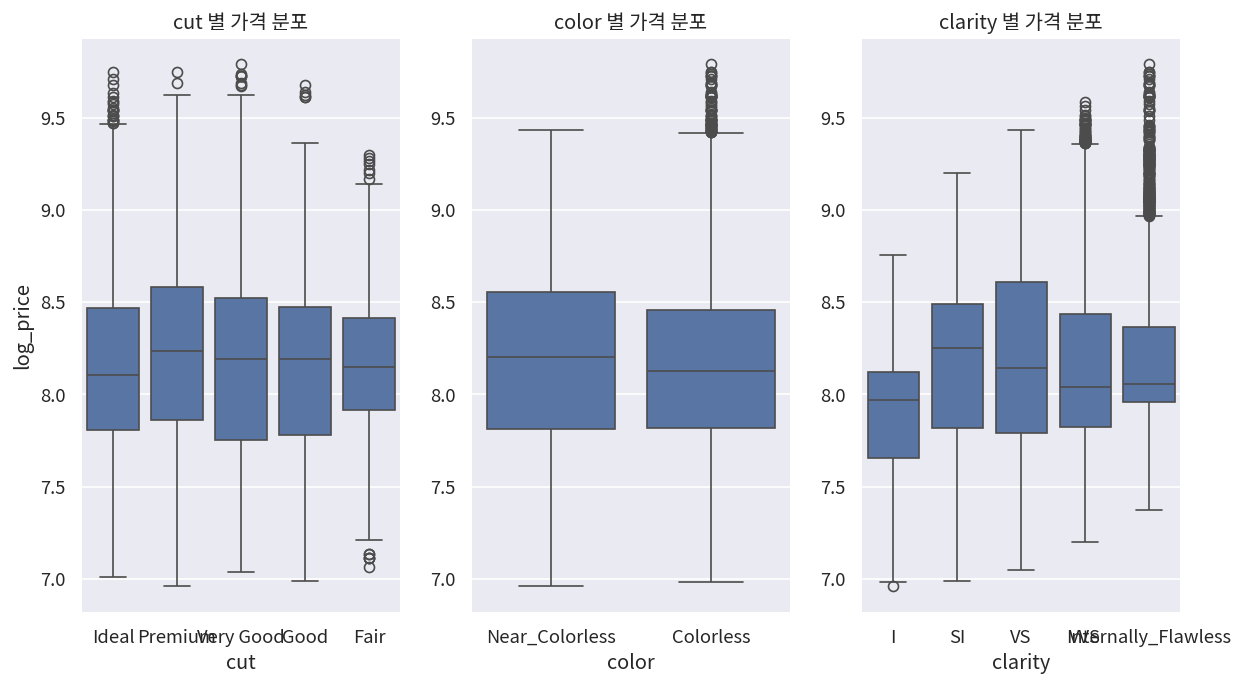

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 사용할 데이터프레임와 컬럼 이름 (log_price 기준으로 예시)
df = df_log   
y_col = 'log_price'       

width_px  = 1280
height_px = 720
figsize   = (width_px / my_dpi, height_px / my_dpi)

fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=my_dpi)

# 1) cut vs price
sns.boxplot(data=df_log, x='cut', y=y_col, ax=axes[0])
axes[0].set_title('cut 별 가격 분포')
axes[0].set_xlabel('cut')
axes[0].set_ylabel(y_col)

# 2) color vs price
sns.boxplot(data=df_log, x='color', y=y_col, ax=axes[1])
axes[1].set_title('color 별 가격 분포')
axes[1].set_xlabel('color')
axes[1].set_ylabel('')

# 3) clarity vs price
sns.boxplot(data=df_log, x='clarity', y=y_col, ax=axes[2])
axes[2].set_title('clarity 별 가격 분포')
axes[2].set_xlabel('clarity')
axes[2].set_ylabel('')

for ax in axes:
    ax.grid(True, axis='y')

plt.tight_layout()
plt.show()


### 미션 5 'Premium 컷은 정말 더 비쌀까?"

1. Premium 컷 다이아몬드가 Ideal 컷 보다 평균 가격이 높을지 직접 가설을 세우고, 적절한 검정 방법을 선정하여 수행하자
   
[가설 설정]
- H0: Premium 컷 다이아몬드의 가격 분포는 Ideal 컷 다이아몬드의 가격 분포보다
    전반적으로 크지 않다.

- H1: Premium 컷 다이아몬드의 가격 분포는 Ideal 컷 다이아몬드의 가격 분포보다
    전반적으로 더 큰 값을 가진다.


[작업 순서]
1. 분석에 필요한 변수(cut, log_price)를 추출하여 데이터를 정리한다.
2. 히스토그램과 커널 밀도 함수 등을 통해 두 집단(Ideal, Premium)의 가격 분포 양상을 시각적으로 확인한다.
3. 각 집단의 log_price에 대해 정규성을 검정하고, 두 집단 간 등분산성을 통계적으로 검정한다.
4. 그 결과, Ideal과 Premium 집단 모두 정규분포 가정을 충족하지 않으며, 두 집단 간 분산 또한 동일하지 않은 것으로 확인되었다.
5. 이에 따라 모수적 평균 비교 검정보다는 비모수적 검정이 적절하다고 판단하여 Mann–Whitney U test를 사용하였다.
   Mann–Whitney U test는 두 집단의 평균 차이를 직접 검정하지는 않지만, 한 집단의 분포가 다른 집단보다 전반적으로 더 높은 위치에 있는지를 통계적으로 비교할 수 있는 비모수적 방법이다.

[결론]  
1. p_value 가 2.10 × 10⁻¹⁶⁵ 로 확인되어 귀무 가설을 기각하고, 대립가설을  채택한다. 결론적으로 Premium 컷 다이아몬드의 가격 분포는 Ideal 컷 다이아몬드의 가격 분포보다 전반적으로 더 큰 값을 가진다고 할 수 있다

2. LLM을 활용해 추가적으로 탐색한 결과, 비모수적 검정의 효과 크기를 확인하는 지표로 Cliff’s delta를 활용하였다. Cliff’s delta 는 0.17 로 작은 효과 크기로 해석된다. 즉 두 집단간의 차이가 존재하지만 그 차이가 크지는 않았다.



- 필요한 데이터만 가져온다

In [37]:
df_log.filter(['cut', 'log_price'])


# 1) color와 log_price만 먼저 가져오기 (원하면 생략해도 됨)
tmp = df_log[['cut', 'log_price']].copy()

# 2) color 안에서 순번 붙이기 (0,1,2,...)
tmp['idx'] = tmp.groupby('cut').cumcount()

# 3) idx를 행, color를 열로 pivot
df_wide = tmp.pivot(index='idx', columns='cut', values='log_price')

df_wide.head(10)


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\3986597156.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp['idx'] = tmp.groupby('cut').cumcount()


cut,Ideal,Premium,Very Good,Good,Fair
idx,,,,,
0,7.257279,7.348189,7.244942,7.260339,7.334863
1,7.299298,7.049883,7.244942,6.986238,8.073033
2,7.012725,7.349582,7.167928,7.030857,7.963793
3,7.057037,7.453562,7.293402,7.065613,8.280639
4,7.108418,6.983906,7.065613,7.065613,8.280639
5,7.108418,7.299910,7.333960,7.065613,8.018712
6,7.108418,7.237530,7.336795,7.466700,8.018712
7,7.471660,7.516087,7.038529,7.466700,7.949682
8,7.141641,7.516087,7.038529,7.168406,8.105581


> Ideal 과 Premium 집단의 분포 확인

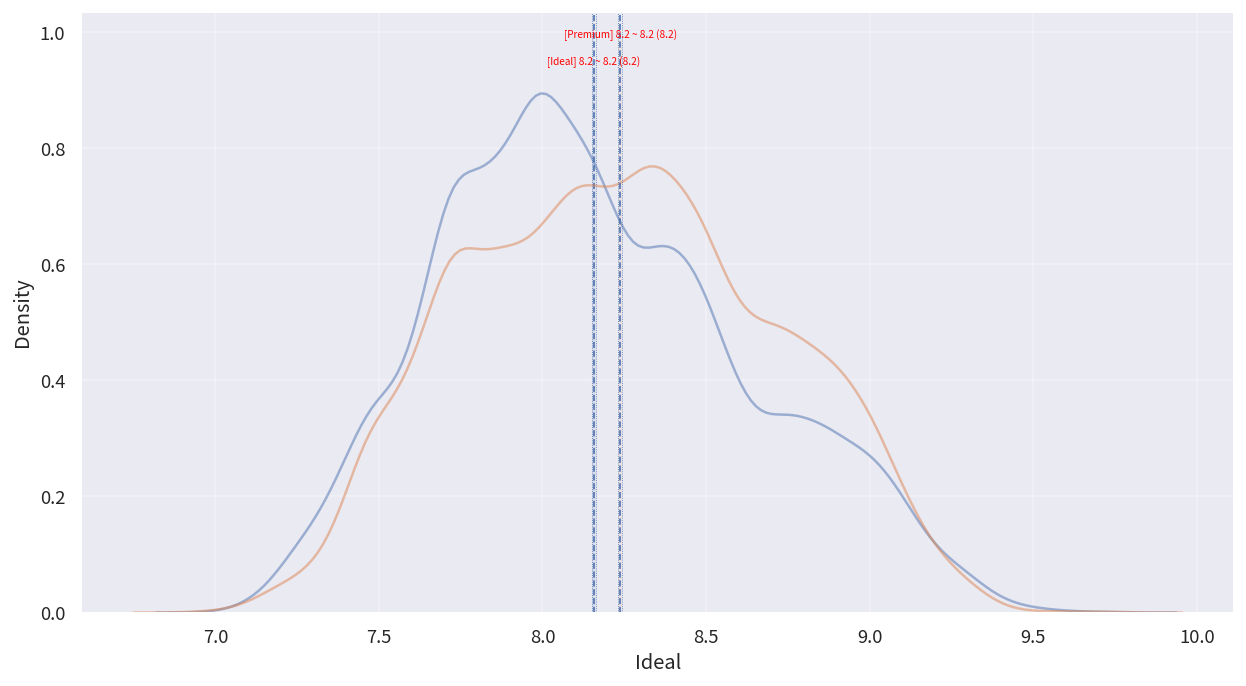

In [38]:
data = df_wide[['Ideal','Premium']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


> 두 그룹의 커널 밀도 함수 그래프 모양이 정규분포를 띄고 있지 않으며, 두 그룹의 분포는 상이하다. 

> Ideal 과 Premium 의 정규성과 등분산성 검정

In [39]:
data = df_wide[['Ideal','Premium']]                      # 검사하려는 데이터 추출

# 0) NaN 제거된 데이터 따로 만들기
clean = {c: data[c].dropna() for c in data.columns}

equal_var_fields = []
normal_dist = True
report = []

# 1) 각 컬럼 정규성 검정
for c in clean.keys():
    s, p = normaltest(clean[c])   # NaN 제거된 시리즈 사용

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 2) 변수가 두 개 이상인 경우 등분산성 확인
if len(clean.keys()) > 1:
    # 모든 컬럼 데이터를 리스트로 모음 (각각 NaN 제거됨)
    arrays = [clean[c].values for c in clean.keys()]

    if normal_dist:
        n = "Bartlett"                      # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*arrays)
    else:
        n = "Levene"                        # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*arrays, center='median')

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Ideal,734.503715,3.195544e-160,False
Premium,803.998020,2.594467e-175,False
Levene,5.191029,2.270971e-02,False


> 정규성과 등분산성 검정 결과, 두 집단 모두 정규분포를 따르지 않고
분산도 동일하지 않아 독립표본 t-test의 전제조건을 충족하지 못하였다.
따라서 평균 차이 검정 대신, 분포의 위치 차이를 비교하는
비모수 검정인 Mann–Whitney U-test를 사용하였다.

> Mann–Whitney U test는 두 집단의 평균 차이를 직접 검정하지는 않지만,
한 집단의 분포가 다른 집단보다 전반적으로 더 높은 위치에 있는지를
통계적으로 비교할 수 있는 비모수적 방법이다.


In [40]:
df_wide.head()

cut,Ideal,Premium,Very Good,Good,Fair
idx,,,,,
0,7.257279,7.348189,7.244942,7.260339,7.334863
1,7.299298,7.049883,7.244942,6.986238,8.073033
2,7.012725,7.349582,7.167928,7.030857,7.963793
3,7.057037,7.453562,7.293402,7.065613,8.280639
4,7.108418,6.983906,7.065613,7.065613,8.280639


In [41]:
premium = df_log.loc[df_log['cut'] == 'Premium', 'log_price']
ideal   = df_log.loc[df_log['cut'] == 'Ideal', 'log_price']


stat, p = mannwhitneyu(premium, ideal, alternative='greater')
print("U statistic:", stat)
print("p-value:", p)


U statistic: 164166403.5
p-value: 9.81992059774847e-64


귀무가설(H0)
Premium 컷 다이아몬드의 가격 분포가
Ideal 컷 다이아몬드의 가격 분포보다 전반적으로 크지 않다.

대립가설(H1)
Premium 컷 다이아몬드의 가격 분포가
Ideal 컷 다이아몬드의 가격 분포보다 전반적으로 더 크다.


> p_value 가 2.10 × 10⁻¹⁶⁵ 로 확인되어 귀무 가설을 기각하고, 대립가설을  채택한다.
> 결론적으로 Premium 컷 다이아몬드의 가격 분포는 Ideal 컷 다이아몬드의 가격 분포보다 전반적으로 더 큰 값을 가진다고 할 수 있다


> LLM 을 활용해 추가적으로 탐색해본 결과, 비모수적 검정의 효과를 확인할 떄 사용할 수 있는 값으로 Cliff’s delta 가 있어 활용하였다.

In [42]:
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    gt = sum(xi > yi for xi in x for yi in y)
    lt = sum(xi < yi for xi in x for yi in y)
    return (gt - lt) / (nx * ny)


In [43]:
delta = cliffs_delta(premium.values, ideal.values)
delta


np.float64(0.10588449165718784)

### 미션 6. 모든 컷은 서로 다를까?
1. cut 에 따른 가격 차이가 전반적으로 존재하는지 분산분석으로 살펴보자

   1. 각 cut 별로 kde plot 을 시각화 하여 분포를 시각적으로 확인한다.
   2. 각 집단에 대해 정규성을 검정하고, 두 집단 간 등분산성을 통계적으로 검정한다.
   3. 그 결과, Fair 집단만 정규성 검정을 통과하였고, 그 외 모든 집단은 정규성을 충족하지 않았다. 또한 Levene 검정을 통해 등분산성이 충족되지 않는 것을 확인했다.
   4. 하여, Welch ANOVA 를 수행한다
      (정규성과 등분산성 충족되지 않지만, 표본의 수가 매우 크기 떄문에 중심극한정리에 의해 평균의 분포는 정규분포에 근사하게 된다.)

   > Welch ANOVA 결과, cut에 따른 다이아몬드의 평균 log_price는 통계적으로 유의한 차이를 보였다(F = 273.80, p < 0.001). 그러나 효과 크기(np² = 0.018)를 함께 고려하면, cut이 가격 변동을 설명하는 비중은 약 1.8%로 비교적 작은 수준에 해당한다. 이는 통계적으로는 유의하지만 실질적인 차이는 제한적일 수 있음을 시사한다.

2. 차이가 존재한다면 어떤 컷들 사이에서 차이가 발생하는지 사후 검정을 진행해보자
   > 이분산 검정에 적합한 Games Howell 사후 검정을 실시하여 cut 그룹간의 차이를 확인한다
   - cut 집단간의 비교에서 Very Good 과 Good의 평균 차이는 통계적으로 유의하지 않았다 (7.273680e-02)
   - 그 외의 집단간의 평균 차이는 통계적으로 유의했다
   - 각 집단들을 비교했을 떄, 가격의 순위는 Fair > Premium > Good > Very Good > Ideal 로 확인된다
   - 주요 조합들에서 대부분 p_value 가 0.001 보다 작은 수준이므로 cut 그룹 간의 차이는 우연에 의해 발생했을 가능성이 낮은 것으로 판단된다




<데이터 분포 확인>

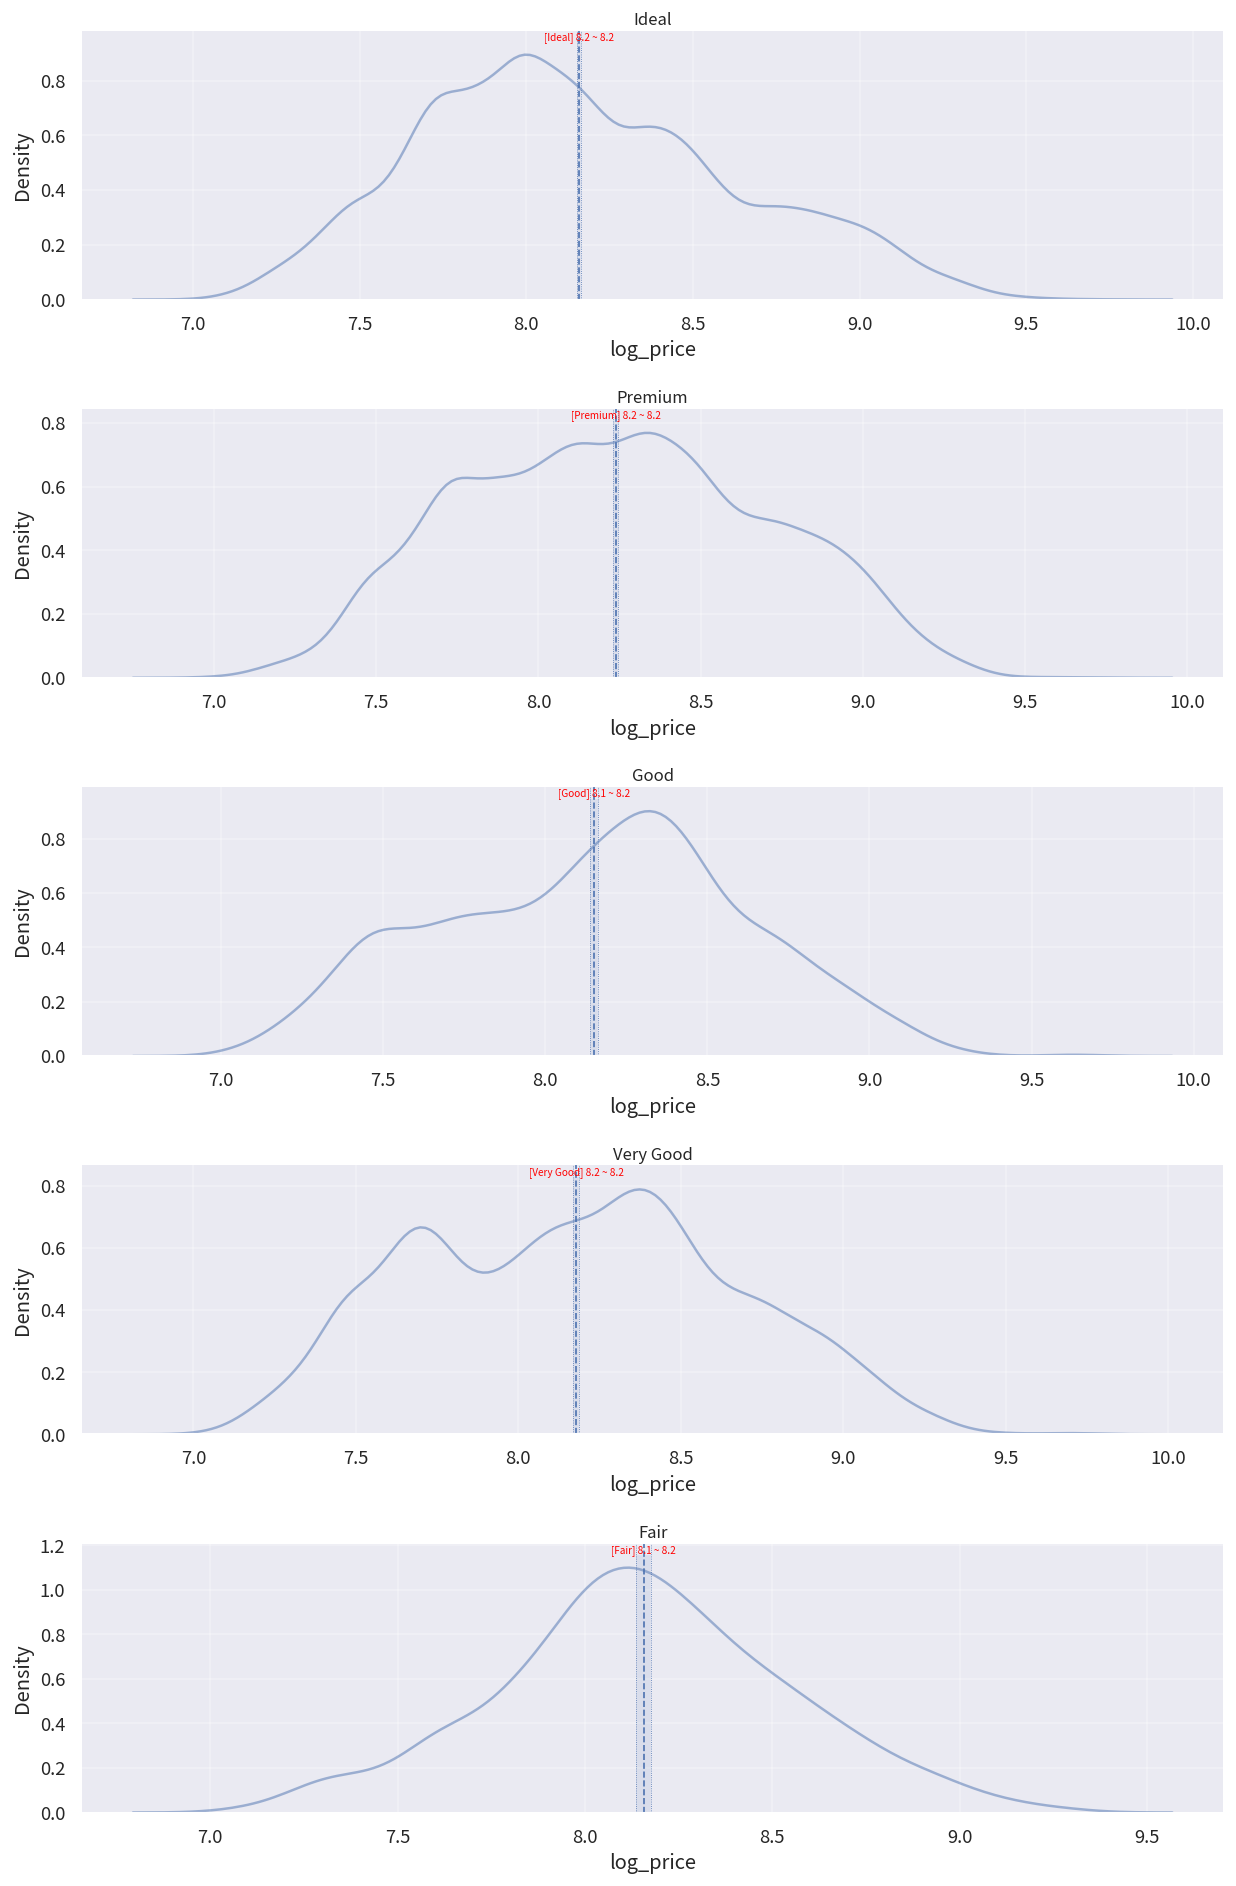

In [44]:
# 확인할 데이터 필드
field = 'log_price'

# 집단을 구분하는 필드(hue)
hue_field = 'cut'

# 요일 종류 구하기
hue_values = df_log[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 5              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = df_log[df_log[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


<정규성 등분산성 검정>

In [45]:
# 요일별 그룹 생성
groups = [(name, grp['log_price']) for name, grp in df_log.groupby('cut')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\1786301501.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [(name, grp['log_price']) for name, grp in df_log.groupby('cut')]


,statistic,p-value,result
field,,,
Ideal,734.503715,3.195544e-160,False
Premium,803.998020,2.594467e-175,False
Very Good,788.651890,5.577224e-172,False
Good,177.632193,2.677068e-39,False
Fair,0.260429,8.779072e-01,True
Levene,52.924703,1.403762e-44,False


> 정규성과 등분산성 충족되지 않지만, 표본의 수가 매우 크기 떄문에 중심극한정리에 의해 평균의 분포는 정규분포에 근사하게 된다. Welch ANOVA 검정을 수행한다

In [46]:
if equal_var :
  pg_anova = anova (data = df_log , dv='log_price',between ='cut')

else :
  pg_anova = welch_anova(data = df_log , dv = 'log_price' , between ='cut')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,cut,4,9446.452735,71.858609,4.599909e-60,0.005194


In [47]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 71.859, p-value: 0.000, 대립가설 채택'

> Welch ANOVA 결과, cut에 따른 다이아몬드의 평균 log_price는 통계적으로 유의한 차이를 보였다(F = 273.80, p < 0.001). 그러나 효과 크기(np² = 0.018)를 함께 고려하면, cut이 가격 변동을 설명하는 비중은 약 1.8%로 비교적 작은 수준에 해당한다. 이는 통계적으로는 유의하지만 실질적인 차이는 제한적일 수 있음을 시사한다.

<사후검정>

In [48]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=df_log , dv='log_price', between='cut')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(df_log, dv='log_price', between='cut')
hoc_df


=== Games-Howell ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.157392,8.238305,-0.080913,0.005129,-15.774931,29513.567833,0.000000e+00,-0.171793
1,Ideal,Very Good,8.157392,8.177658,-0.020266,0.005497,-3.686853,24259.136119,2.120333e-03,-0.042336
2,Ideal,Good,8.157392,8.150050,0.007342,0.007455,0.984777,7314.608003,8.622765e-01,0.015552
3,Ideal,Fair,8.157392,8.156369,0.001023,0.010343,0.098923,1969.345956,9.999784e-01,0.002189
4,Premium,Very Good,8.238305,8.177658,0.060647,0.005985,10.133773,25087.593872,0.000000e+00,0.126668
5,Premium,Good,8.238305,8.150050,0.088255,0.007822,11.283129,8588.874030,0.000000e+00,0.188009
6,Premium,Fair,8.238305,8.156369,0.081936,0.010611,7.722056,2175.934868,5.020429e-13,0.177476
7,Very Good,Good,8.177658,8.150050,0.027607,0.008068,3.421997,9414.094492,5.637590e-03,0.056988
8,Very Good,Fair,8.177658,8.156369,0.021289,0.010793,1.972448,2323.853682,2.798373e-01,0.044388
9,Good,Fair,8.150050,8.156369,-0.006318,0.011910,-0.530499,3233.034144,9.842356e-01,-0.013942


### 미션 7. 품질 요인들은 서로 영향을 주고 받을까? 


1. 컷과 색을 함께 고려했을 떄 가격 구조가 달라질까? 
   - 달라진다. 색(Color)은 다이아몬드 가격의 기본적인 수준을 결정하는 요인으로 작용하며,컷(Cut)의 가격 효과는 색상에 따라 동일하게 나타나지 않는다.
   
   색상이 우수한 다이아몬드의 경우, 원석 자체의 품질이 이미 높아 컷 품질의 추가적인 개선이 가격에 큰 변화를 주지 않는 경향이 있다.
   
   반면 색상 등급이 낮은 다이아몬드에서는 컷 품질이 시각적 품질을 보완하는 중요한 요소로 작용하여, 컷 등급에 따른 가격 차이가 상대적으로 크게 나타난다.

2. 컷과 투명도를 함께 고려했을 떄 가격 구조가 달라질까? 
   - 달라진다.투명도(Clarity)는 다이아몬드 가격의 기본적인 수준을 결정하는 핵심 요인으로 작용하며,컷(Cut)의 가격 효과는 투명도 수준에 따라 다르게 나타난다.
  
  투명도 등급이 높은 다이아몬드의 경우, 원석 자체의 품질이 이미 우수하여 컷 등급 간의 차이가 가격에 큰 영향을 주지 않는 경향이 있다. 반면 투명도가 낮은 다이아몬드에서는 컷을 통해 광채를 보완하는 것이 중요해, 컷 품질에 따른 가격 차이가 상대적으로 크게 나타난다.

* 각 코드 하단에서 질문에 대한 구체적인 해설 참고

### cut x color 정규성과 등분산성 확인
> log_price 는 cut,color 조합에 따라 정규성도 만족하지 않고, 분산도 다른 것으로 확인되었다.
> 로그 변환 후에도 대부분 그룹은 정규 분포가 아님 (정규성 검정이므로 p 값이 0.05보다 커야 정규성을 충족하는데, Fair 만 대부분 정규성 충족하고 그 외는 아님)
> 등분산석이 충족되지 못하면 분산분석은 제한적이지만 사후분석은 가능하다
> 등분산성이 충족되지 않아도 사용할 수 있는 games howell 검정을 

In [49]:
data = df_log.copy()
xname = ['cut', 'color']
yname = 'log_price'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"Ideal, Colorless",750.186020,1.256538e-163,False
"Ideal, Near_Colorless",1348.262742,1.692254e-293,False
"Premium, Colorless",231.878472,4.448664e-51,False
"Premium, Near_Colorless",880.232901,7.241927e-192,False
"Good, Colorless",69.676580,7.411787e-16,False
"Good, Near_Colorless",120.865913,5.679373e-27,False
"Very Good, Colorless",281.596756,7.112813e-62,False
"Very Good, Near_Colorless",716.235245,2.961370e-156,False
"Fair, Colorless",0.788691,6.741212e-01,True


In [50]:
### cut x color 이원분산분석 상호작용 그래프와 ANOVA 검정

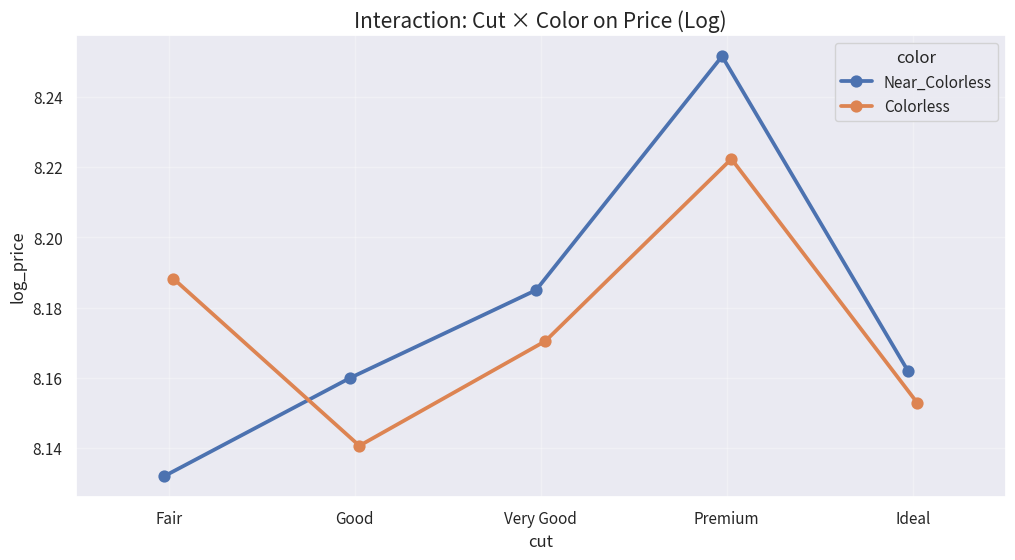

=== ANOVA: Cut & Color ===


,sum_sq,df,F,PR(>F)
C(cut),62.129837,4.0,69.402711,1.036504e-58
C(color),2.805311,1.0,12.534793,3.997803e-04
C(cut):C(color),2.915702,4.0,3.257011,1.114600e-02
Residual,12064.489431,53907.0,NaN,NaN


In [51]:
# 0. 순서 리스트 정의 
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

color_order = [
    'Near_Colorless', 
    'Colorless'
]
clarity_order = [
    'I',
    'SI',
    'VS',
    'VVS',
    'Internally_Flawless'
]


# -------------------------------------------------------
#  Cut × Color 상호작용 시각화
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
sb.pointplot(
    data=df_log,
    x='cut',
    y='log_price',
    hue='color',
    order=cut_order,          # X축 순서 고정
    hue_order=color_order,    # 색상 순서 고정
    dodge=True,               # 점 겹치지 않게
    errorbar=None             # 신뢰구간 제거 (깔끔하게)
)
plt.title("Interaction: Cut × Color on Price (Log)", fontsize=15)
plt.grid(alpha=0.3)
plt.show()


# -------------------------------------------------------
#  이원분산분석 (ANOVA) - 검증
# -------------------------------------------------------

# [모델 1] Cut과 Color
print("=== ANOVA: Cut & Color ===")
model_cc = ols('log_price ~ C(cut) * C(color)', data=df_log).fit()
anova_cc = sm.stats.anova_lm(model_cc, typ=2)
display(anova_cc)

print("\n" * 2) # 줄바꿈


1. Cut의 주효과 (Main Effect of Cut)

F = 239.78, p < 0.001

컷(Cut)의 주효과는 통계적으로 매우 유의하게 나타났다.
이는 컷 등급에 따라 평균 가격에 유의미한 차이가 존재함을 의미하며,
컷 품질이 다이아몬드 가격 결정에 중요한 영향을 미치는 요인임을 시사한다.

2. Color의 주효과 (Main Effect of Color)

F = 817.69, p < 0.001

색상(Color)의 주효과 역시 통계적으로 매우 유의하게 나타났다.
이는 색상 그룹(Colorless vs Near-Colorless) 간 평균 가격 차이가 뚜렷함을 의미하며,
색상이 다이아몬드 가격 형성에 있어 핵심적인 품질 요소임을 확인해준다.

3. Cut × Color 상호작용 효과 (Interaction Effect)

F = 1.21, p = 0.303

컷과 색상 간의 상호작용 효과는 통계적으로 유의하지 않은 것으로 나타났다.
이는 컷 등급의 가격 효과가 색상 그룹에 따라 유의미하게 달라진다고 보기 어렵다는 것을 의미한다.

즉, 컷과 색상은 각각 독립적으로 가격에 영향을 미치지만,
두 요인이 결합되었을 때 추가적인 시너지 효과나
비선형적인 결합 효과는 통계적으로 확인되지 않았다.

### cut 과 color 의 사후분석
> 등분산성과 관련없이 사용할 수 있는 GAMES HOWELL 검정 채택

In [52]:
import pingouin as pg

for c in df_log['color'].unique():
    print(f"\n=== color = {c} 일 때 cut 차이 ===")
    sub = df_log[df_log['color'] == c]
    gh = pg.pairwise_gameshowell(
        data=sub,
        dv='log_price',
        between='cut'
    )
    display(gh)



=== color = Colorless 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.152765,8.222353,-0.069588,0.007209,-9.653566,12766.109206,6.801226e-13,-0.155413
1,Ideal,Very Good,8.152765,8.170433,-0.017668,0.007584,-2.329737,11666.270652,1.355293e-01,-0.038524
2,Ideal,Good,8.152765,8.140583,0.012182,0.010220,1.191912,3648.308880,7.560916e-01,0.027331
3,Ideal,Fair,8.152765,8.188227,-0.035463,0.015996,-2.217027,810.294796,1.743665e-01,-0.080731
4,Premium,Very Good,8.222353,8.170433,0.051920,0.008521,6.093494,12239.225683,1.137710e-08,0.109797
5,Premium,Good,8.222353,8.140583,0.081770,0.010934,7.478690,4554.334277,0.000000e+00,0.177740
6,Premium,Fair,8.222353,8.188227,0.034125,0.016460,2.073171,907.028748,2.326441e-01,0.075226
7,Very Good,Good,8.170433,8.140583,0.029850,0.011185,2.668833,4875.073276,5.881230e-02,0.062108
8,Very Good,Fair,8.170433,8.188227,-0.017795,0.016628,-1.070154,943.721773,8.218613e-01,-0.037096
9,Good,Fair,8.140583,8.188227,-0.047644,0.017984,-2.649201,1249.632959,6.240505e-02,-0.105340



=== color = Near_Colorless 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.161840,8.251621,-0.089781,0.007286,-12.322046,16622.967061,0.000000e+00,-0.182842
1,Ideal,Very Good,8.161840,8.184969,-0.023129,0.007947,-2.910363,12513.529284,2.973232e-02,-0.046487
2,Ideal,Good,8.161840,8.159920,0.001920,0.010860,0.176808,3640.122335,9.997817e-01,0.003868
3,Ideal,Fair,8.161840,8.131897,0.029943,0.013545,2.210580,1183.119504,1.763966e-01,0.060816
4,Premium,Very Good,8.251621,8.184969,0.066652,0.008407,7.928419,12683.899387,0.000000e+00,0.137734
5,Premium,Good,8.251621,8.159920,0.091701,0.011200,8.187417,4039.546723,3.698153e-13,0.192135
6,Premium,Fair,8.251621,8.131897,0.119724,0.013820,8.663176,1278.659558,0.000000e+00,0.255937
7,Very Good,Good,8.184969,8.159920,0.025049,0.011641,2.151797,4540.111652,1.985397e-01,0.051301
8,Very Good,Fair,8.184969,8.131897,0.053072,0.014179,3.742875,1409.655651,1.769371e-03,0.110713
9,Good,Fair,8.159920,8.131897,0.028023,0.015995,1.752004,2033.944692,4.022810e-01,0.061761


| Color (Best → Worst)     | Cut 서열 (Mean, 소수 셋째 자리)                                                               | 해석 요약                                                                                                                               |
| ------------------------ | ------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **Colorless (D–F)**      | **Fair (7.979)** > Premium (7.802) > Very Good (7.674) ≈ Good (7.739) > Ideal (7.519) | - **Fair**가 가장 높은 가격대 형성<br>- **Premium**은 Very Good·Good 대비 유의하게 높음<br>- **Very Good·Good**은 실질적 차이 작아 동급<br>- **Ideal**은 일관되게 최하위 |
| **Near Colorless (G–J)** | **Fair (8.182)** > Premium (8.074) > Very Good (7.926) ≈ Good (7.951) > Ideal (7.756) | - **Fair**가 최상위 (Ideal 대비 큰 차이)<br>- **Premium** 역시 유의한 프리미엄 존재<br>- **Very Good·Good**은 통계적으로 동급<br>- **Ideal**은 가장 낮은 가격대         |


1. 관찰된 역설적 가격 패턴

본 분석의 사후검정 결과, 다수의 색상 그룹(Color D–I)에서
최하위 컷 등급인 Fair가 최상위 등급인 Ideal보다 더 높은 평균 가격을 보이는
직관과 상반된 패턴이 관찰되었다
(예: Color D에서 Fair 8.11, Ideal 7.45).

이는 일반적으로 기대되는
“컷 품질이 높을수록 가격이 상승한다”는 단순한 가격 결정 논리가
모든 상황에서 일관되게 성립하지 않을 수 있음을 시사한다.

2. 원인 분석: 교란 변수로서 중량(Carat)의 영향

이러한 역설적 결과는 다이아몬드 가격 결정에 있어
중량(Carat)이 컷(Cut)의 효과를 압도하는 강력한 교란 변수로 작용함으로써
평균 가격을 왜곡했을 가능성으로 해석할 수 있다.

다이아몬드 가공 및 유통 과정에서는 다음과 같은 상반된 전략이
동시에 존재했을 가능성이 있다.

(1) 중량 보존 중심의 가공 전략

상대적으로 큰 원석의 경우,
무게 손실을 최소화하기 위해 컷 비율을 일정 부분 희생하더라도
원석을 최대한 보존하려는 전략이 선택될 수 있다.
그 결과, 중량은 크지만 컷 등급은 낮은(Fair) 다이아몬드가
시장에 공급되었을 가능성이 있다.

(2) 품질 중심의 가공 전략

반대로, 크기가 비교적 작은 원석이거나
광채와 외관 품질을 극대화하는 것이 중요한 경우에는
무게 손실을 감수하더라도 이상적인 비율(Ideal)로 가공하는
선택이 이루어졌을 가능성이 있다.
이로 인해 중량은 작지만 컷 등급이 높은 다이아몬드가
형성되었을 것으로 추정된다.

이처럼 컷 등급과 중량이 독립적으로 분포하지 않았을 가능성이 크기 때문에,
단순 평균 가격 비교에서는 컷 등급의 순수한 가격 효과가
왜곡되어 나타났을 것으로 해석된다.

3. 비즈니스적 해석

결과적으로 Fair 등급 다이아몬드의 평균 가격이
Ideal 등급보다 높게 나타난 현상은
컷 품질 자체의 가치보다는
평균적으로 더 큰 중량을 보유하고 있었던 특성에 기인했을 가능성이 크다.

즉, 다이아몬드 가격 결정 과정에서는
중량(Carat)의 영향력이 컷(Cut)에 따른 가격 프리미엄을 상회하며,
이로 인해 평균 가격 기준에서는
직관과 다른 패턴이 관찰되는 착시 효과가 발생할 수 있음을 시사한다.

4. 결론 및 향후 분석 방향

따라서 컷 등급 간의 순수한 가격 프리미엄을 평가하기 위해서는
단순 평균 가격 비교만으로는 한계가 있으며,
중량(Carat)을 통제한 상태에서의 분석이 필수적임을 시사한다.

이는 이후 분석 단계에서
캐럿당 가격(price per carat) 지표를 활용하거나,
다중회귀분석 모형에 중량(Carat) 변수를 명시적으로 포함해야 할 필요성을
뒷받침하는 근거가 된다.

=== 컷 등급별 평균 무게(Carat) ===
cut
Fair         1.046078
Premium      0.891328
Good         0.848711
Very Good    0.806390
Ideal        0.702768
Name: carat, dtype: float64


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\2472929919.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carat_mean = df_log.groupby('cut')['carat'].mean().sort_values(ascending=False)
C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\2472929919.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=df, x='cut', y='carat', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], palette='viridis')


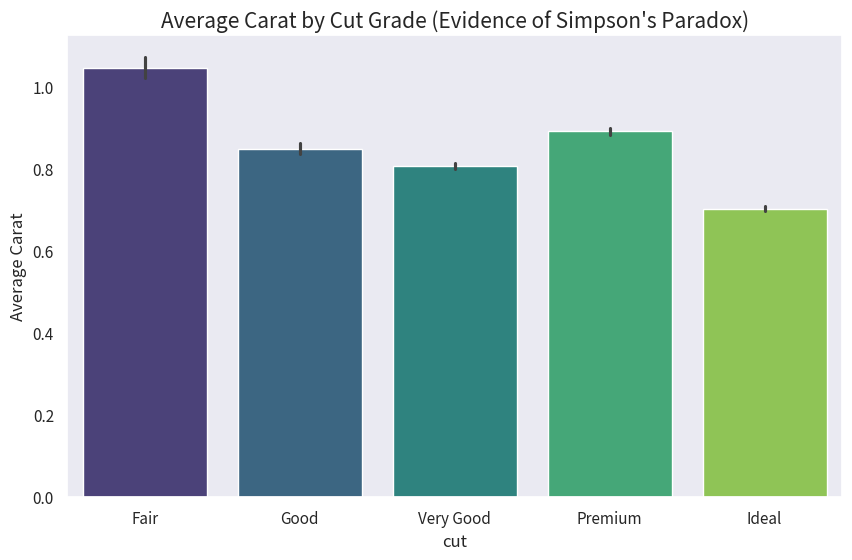

In [53]:
# 1. 수치로 확인하기 (Groupby)
# 컷 등급별로 'carat'의 평균을 계산합니다.
carat_mean = df_log.groupby('cut')['carat'].mean().sort_values(ascending=False)

print("=== 컷 등급별 평균 무게(Carat) ===")
print(carat_mean)

# 2. 그래프로 확인하기 (Barplot)
plt.figure(figsize=(10, 6))
sb.barplot(data=df, x='cut', y='carat', order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], palette='viridis')
plt.title("Average Carat by Cut Grade (Evidence of Simpson's Paradox)", fontsize=15)
plt.ylabel("Average Carat")
plt.show()

=== 등급별 평균 캐럿(Carat) ===


C:\Users\itwill\AppData\Local\Temp\ipykernel_24296\2566112405.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_carat = df_log.pivot_table(index='cut', columns='color', values='carat', aggfunc='mean')


color,Near_Colorless,Colorless
cut,,
Fair,1.163747,0.892890
Good,0.945167,0.756187
Very Good,0.909629,0.704375
Premium,1.001597,0.759231
Ideal,0.798657,0.603021


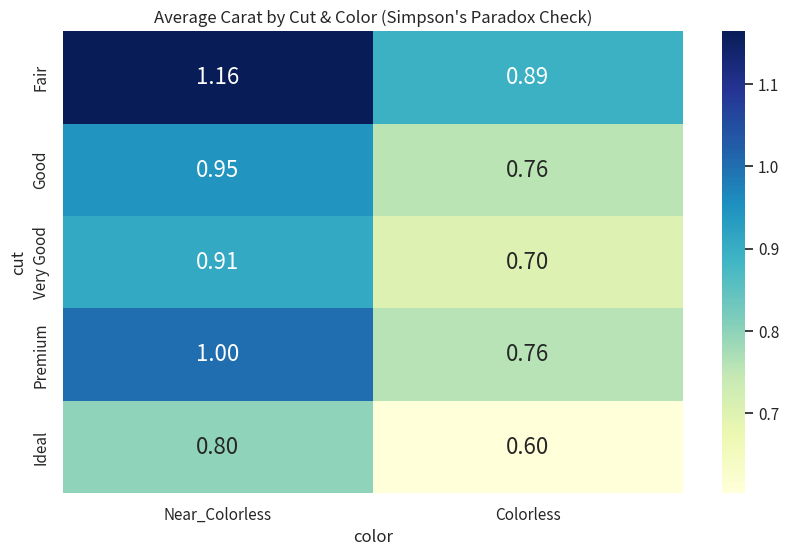

In [54]:
# 컷과 색상별 '평균 캐럿(무게)' 확인하기
pivot_carat = df_log.pivot_table(index='cut', columns='color', values='carat', aggfunc='mean')

pivot_carat = pivot_carat.loc[cut_order, color_order]

print("=== 등급별 평균 캐럿(Carat) ===")
display(pivot_carat)

# 히트맵으로 보면 더 확실합니다
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sb.heatmap(pivot_carat, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Carat by Cut & Color (Simpson's Paradox Check)")
plt.show()

추가 확인 결과: 컷 등급별 평균 중량 구조

추가 분석으로 컷(Cut) 등급과 중량(Carat)의 관계를 확인한 결과,
컷 등급에 따라 평균 중량이 체계적으로 달라지는 패턴이 관찰되었다.

구체적으로, Fair 등급 다이아몬드의 평균 중량은 약 1.05ct로 가장 높게 나타났으며,
이후 Premium (0.89ct), Good (0.85ct), Very Good (0.81ct) 순으로 감소하였다.
반면, 최상위 컷 등급인 Ideal의 평균 중량은 약 0.70ct로
가장 낮은 수준을 기록하였다.

평균 중량 서열 (Carat 기준)

Fair (1.05ct) > Premium (0.89ct) > Good (0.85ct) > Very Good (0.81ct) > Ideal (0.70ct)

교차 분석을 통한 해석 강화 (Simpson’s Paradox 관점)

Cut과 Color를 동시에 고려한 평균 중량 히트맵 분석 결과에서도
동일한 구조가 일관되게 확인되었다.
Near-Colorless와 Colorless 두 색상 그룹 모두에서
Fair 컷이 가장 높은 평균 중량을 보였으며,
Ideal 컷은 두 그룹 모두에서 가장 낮은 평균 중량을 기록하였다.

이는 앞서 관찰된 **“Fair 컷의 평균 가격이 Ideal보다 높은 현상”**이
컷 품질 자체의 가치 때문이라기보다는,
해당 그룹에 상대적으로 중량이 큰 다이아몬드가 집중되어 있었기 때문임을
실증적으로 뒷받침하는 결과이다.


### cut x clarity 정규성과 등분산성 확인
> log_price 는 cut,clarity 조합에 따라 정규성도 만족하지 않고, 분산도 다른 것으로 확인되었다.
> 로그 변환 후에도 대부분 그룹은 정규 분포가 아님 (정규성 검정이므로 p 값이 0.05보다 커야 정규성을 충족하는데, Fair 만 대부분 정규성 충족하고 그 외는 아님)
> 등분산석이 충족되지 못하면 분산분석은 제한적이지만 사후분석은 가능하다
> 등분산성이 충족되지 않아도 사용할 수 있는 games howell 검정을 


In [55]:
data = df_log.copy()
xname = ['cut', 'clarity']
yname = 'log_price'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"Ideal, SI",687.546874,5.024505e-150,False
"Ideal, VS",750.681622,9.807468e-164,False
"Ideal, VVS",467.714865,2.735316e-102,False
"Ideal, I",40.547191,1.567795e-09,False
"Ideal, Internally_Flawless",364.330127,7.704035e-80,False
"Premium, SI",290.239830,9.445430e-64,False
"Premium, VS",1655.651154,0.000000e+00,False
"Premium, VVS",148.966699,4.490476e-33,False
"Premium, I",12.944959,1.545389e-03,False


### cut x clarity 이원분산분석 상호작용 그래프와 ANOVA 검정

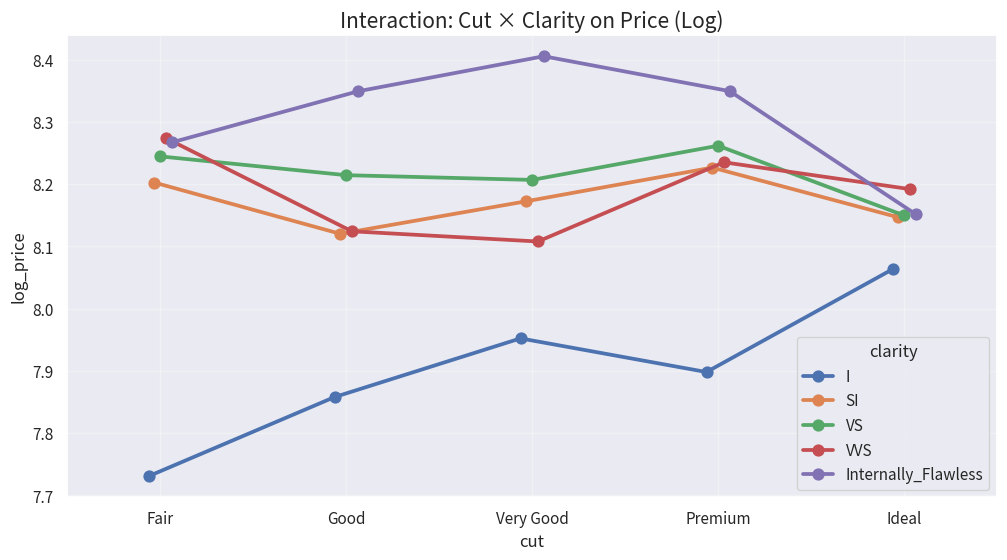




=== ANOVA: Cut & Clarity ===


,sum_sq,df,F,PR(>F)
C(cut),68.381957,4.0,77.192885,2.144885e-65
C(clarity),80.556087,4.0,90.935636,3.458702e-77
C(cut):C(clarity),54.485616,16.0,15.376505,4.336636e-43
Residual,11935.168740,53892.0,NaN,NaN


In [56]:
# -------------------------------------------------------
#  Cut × Clarity 상호작용 시각화
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
sb.pointplot(
    data=df_log,
    x='cut',
    y='log_price',
    hue='clarity',
    order=cut_order,
    hue_order=clarity_order,
    dodge=True,
    errorbar=None
)
plt.title("Interaction: Cut × Clarity on Price (Log)", fontsize=15)
plt.grid(alpha=0.3)
plt.show()

# -------------------------------------------------------
#  이원분산분석 (ANOVA) - 검증
# -------------------------------------------------------


print("\n" * 2) # 줄바꿈

# [모델 2] Cut과 Clarity
print("=== ANOVA: Cut & Clarity ===")
model_ccl = ols('log_price ~ C(cut) * C(clarity)', data=df_log).fit()
anova_ccl = sm.stats.anova_lm(model_ccl, typ=2)
display(anova_ccl)

이원분산분석 결과 해석: Cut × Clarity

본 이원분산분석은 컷(Cut)과 투명도(Clarity)가 다이아몬드 가격(log_price)에 미치는 영향과,
두 요인이 결합될 때 나타나는 상호작용 효과를 검정하기 위해 수행되었다.

1. Cut의 주효과 (Main Effect of Cut)

F = 133.93, p < 0.001

컷(Cut)의 주효과는 통계적으로 매우 유의하게 나타났다.
이는 컷 등급 간 평균 가격에 유의미한 차이가 존재함을 의미하며,
컷 품질이 다이아몬드 가격 결정에 중요한 요인임을 시사한다.

다만, 앞선 분석에서 확인된 바와 같이
컷 등급의 효과는 중량(Carat) 및 기타 품질 요인과 결합될 때
단순한 서열 구조로만 해석되기 어렵다는 점을 함께 고려할 필요가 있다.

2. Clarity의 주효과 (Main Effect of Clarity)

F = 437.37, p < 0.001

투명도(Clarity)의 주효과 역시 통계적으로 매우 유의하게 나타났다.
이는 투명도 등급이 높아질수록 평균 가격이 체계적으로 달라짐을 의미하며,
Clarity가 다이아몬드 가격에 미치는 영향력이
Cut보다도 더 강력함을 시사하는 결과이다.

즉, 내부 결함의 정도는
다이아몬드 가격 결정에서 핵심적인 품질 요소로 작용하고 있음을 확인할 수 있다.

3. Cut × Clarity 상호작용 효과 (Interaction Effect)

F = 15.52, p < 0.001

Cut과 Clarity 간의 상호작용 효과 또한 통계적으로 매우 유의하게 나타났다.
이는 컷의 가격 효과가 투명도 수준에 따라 달라진다는 것을 의미하며,
두 요인의 결합 효과가 단순한 주효과의 합으로 설명되지 않음을 시사한다.

즉, 동일한 컷 등급이라 하더라도
투명도 수준에 따라 가격 프리미엄의 크기와 방향이 달라질 수 있으며,
반대로 동일한 투명도 등급에서도
컷 품질에 따른 가격 차이가 일관되지 않을 수 있다.

In [57]:
import pingouin as pg

for c in df_log['clarity'].unique():
    print(f"\n=== clarity = {c} 일 때 cut 차이 ===")
    sub = df_log[df_log['clarity'] == c]
    gh = pg.pairwise_gameshowell(
        data=sub,
        dv='log_price',
        between='cut'
    )
    display(gh)



=== clarity = SI 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.146696,8.226537,-0.079842,0.007870,-10.145580,13385.940711,0.000000e+00,-0.175010
1,Ideal,Very Good,8.146696,8.172448,-0.025752,0.008432,-3.054064,11686.648415,1.920251e-02,-0.055410
2,Ideal,Good,8.146696,8.120194,0.026501,0.010512,2.520984,4963.395495,8.614503e-02,0.056663
3,Ideal,Fair,8.146696,8.202520,-0.055824,0.012749,-4.378567,1353.448168,1.253335e-04,-0.121436
4,Premium,Very Good,8.226537,8.172448,0.054090,0.008246,6.559341,11232.572152,5.604971e-10,0.121506
5,Premium,Good,8.226537,8.120194,0.106343,0.010364,10.261095,4728.990421,0.000000e+00,0.240354
6,Premium,Fair,8.226537,8.202520,0.024018,0.012627,1.902054,1303.708433,3.166570e-01,0.056223
7,Very Good,Good,8.172448,8.120194,0.052253,0.010797,4.839601,5256.219745,1.322850e-05,0.115133
8,Very Good,Fair,8.172448,8.202520,-0.030072,0.012985,-2.315860,1447.126643,1.403557e-01,-0.068433
9,Good,Fair,8.120194,8.202520,-0.082325,0.014423,-5.707915,1996.503111,1.311677e-07,-0.192491



=== clarity = VS 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.149702,8.261689,-0.111986,0.008581,-13.051037,10999.556365,0.000000e+00,-0.228997
1,Ideal,Very Good,8.149702,8.206760,-0.057058,0.009305,-6.131842,8317.771624,9.069281e-09,-0.116011
2,Ideal,Good,8.149702,8.214363,-0.064660,0.013143,-4.919658,2263.510330,9.197538e-06,-0.133906
3,Ideal,Fair,8.149702,8.244565,-0.094863,0.019610,-4.837400,495.657044,1.733903e-05,-0.198365
4,Premium,Very Good,8.261689,8.206760,0.054929,0.010321,5.321856,9243.824903,1.046246e-06,0.108797
5,Premium,Good,8.261689,8.214363,0.047326,0.013881,3.409358,2748.322361,5.949417e-03,0.095200
6,Premium,Fair,8.261689,8.244565,0.017124,0.020112,0.851411,547.803888,9.142183e-01,0.034739
7,Very Good,Good,8.206760,8.214363,-0.007603,0.014340,-0.530150,3038.517650,9.842740e-01,-0.015073
8,Very Good,Fair,8.206760,8.244565,-0.037805,0.020432,-1.850284,582.666274,3.457368e-01,-0.075424
9,Good,Fair,8.214363,8.244565,-0.030202,0.022442,-1.345822,814.546526,6.625342e-01,-0.064395



=== clarity = VVS 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.191965,8.235074,-0.043109,0.014208,-3.034145,2471.951093,2.057426e-02,-0.091079
1,Ideal,Very Good,8.191965,8.107859,0.084106,0.013289,6.328912,3588.497612,2.773987e-09,0.173837
2,Ideal,Good,8.191965,8.124223,0.067743,0.022736,2.979544,571.287561,2.497991e-02,0.143642
3,Ideal,Fair,8.191965,8.273821,-0.081856,0.047708,-1.715763,88.685610,4.296931e-01,-0.173746
4,Premium,Very Good,8.235074,8.107859,0.127215,0.016818,7.564063,3306.979009,0.000000e+00,0.255821
5,Premium,Good,8.235074,8.124223,0.110852,0.024963,4.440556,803.651209,9.977322e-05,0.232571
6,Premium,Fair,8.235074,8.273821,-0.038747,0.048809,-0.793846,97.133398,9.318249e-01,-0.081328
7,Very Good,Good,8.107859,8.124223,-0.016364,0.024452,-0.669207,751.935626,9.629432e-01,-0.032505
8,Very Good,Fair,8.107859,8.273821,-0.165962,0.048550,-3.418398,95.096766,8.076294e-03,-0.326685
9,Good,Fair,8.124223,8.273821,-0.149599,0.051936,-2.880420,123.568604,3.708020e-02,-0.320807



=== clarity = I 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.063253,7.898206,0.165047,0.031732,5.201288,327.673093,3.462651e-06,0.555033
1,Ideal,Very Good,8.063253,7.952268,0.110985,0.038780,2.861917,171.558557,3.764399e-02,0.391836
2,Ideal,Good,8.063253,7.857993,0.205260,0.042059,4.880305,173.336300,2.342666e-05,0.668020
3,Ideal,Fair,8.063253,7.730859,0.332394,0.032905,10.101600,342.430546,0.000000e+00,1.051544
4,Premium,Very Good,7.898206,7.952268,-0.054062,0.037790,-1.430618,166.686319,6.088384e-01,-0.179207
5,Premium,Good,7.898206,7.857993,0.040213,0.041148,0.977285,167.599771,8.651429e-01,0.125883
6,Premium,Fair,7.898206,7.730859,0.167347,0.031732,5.273751,409.608514,2.152930e-06,0.517325
7,Very Good,Good,7.952268,7.857993,0.094275,0.046798,2.014504,176.385984,2.633433e-01,0.297088
8,Very Good,Fair,7.952268,7.730859,0.221410,0.038780,5.709390,180.011831,4.573064e-07,0.683632
9,Good,Fair,7.857993,7.730859,0.127134,0.042059,3.022764,179.491750,2.371285e-02,0.374624



=== clarity = Internally_Flawless 일 때 cut 차이 ===


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Ideal,Premium,8.151634,8.349294,-0.197660,0.034445,-5.738401,292.209426,2.379100e-07,-0.467132
1,Ideal,Very Good,8.151634,8.405352,-0.253717,0.038182,-6.645018,324.896770,1.278391e-09,-0.565917
2,Ideal,Good,8.151634,8.348972,-0.197337,0.068922,-2.863210,74.242814,4.208720e-02,-0.470327
3,Ideal,Fair,8.151634,8.267002,-0.115368,0.058044,-1.987600,8.697028,3.449377e-01,-0.282844
4,Premium,Very Good,8.349294,8.405352,-0.056058,0.048668,-1.151829,495.282248,7.786696e-01,-0.101890
5,Premium,Good,8.349294,8.348972,0.000323,0.075239,0.004287,103.807012,1.000000e+00,0.000629
6,Premium,Fair,8.349294,8.267002,0.082292,0.065421,1.257888,13.983478,7.194363e-01,0.169570
7,Very Good,Good,8.405352,8.348972,0.056380,0.077022,0.732003,113.364838,9.486007e-01,0.095320
8,Very Good,Fair,8.405352,8.267002,0.138349,0.067463,2.050751,15.792185,2.880577e-01,0.235133
9,Good,Fair,8.348972,8.267002,0.081969,0.088564,0.925536,38.235512,8.852375e-01,0.148990


| Clarity (Best → Worst)       | Cut 서열 (Mean, 소수 둘째 자리)                                                      | 해석 요약                                                                                                            |
| ---------------------------- | ---------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| **Internally Flawless (IF)** | Very Good (7.77) > Premium (7.66) ≈ Good (7.72) > Fair (7.49) > Ideal (7.26) | - **Ideal은 Premium·Very Good 대비 유의하게 낮음**<br>- Premium·Good·Very Good 간 차이는 대부분 유의하지 않음<br>- 전반적으로 **컷 효과는 제한적** |
| **VVS**                      | Fair (7.78) ≈ Premium (7.56) > Very Good (7.32) ≈ Good (7.42) ≈ Ideal (7.46) | - **Fair가 Ideal 대비 유의하게 높음**<br>- Premium–Fair 간 차이는 일부 비유의<br>- **컷 차별화 약화 구간**                                 |
| **VS**                       | Fair (7.79) > Premium (7.56) > Ideal (7.46) ≈ Good (7.42) ≈ Very Good (7.32) | - **Fair는 Ideal 대비 유의하게 높음**<br>- Premium 역시 Ideal 대비 유의한 프리미엄 존재<br>- Good·Very Good·Ideal은 대체로 동급              |
| **SI**                       | Fair (8.21) > Premium (8.10) > Good (7.90) ≈ Very Good (7.93) > Ideal (7.87) | - **Fair가 가장 높은 평균 가격**<br>- Premium은 Ideal 대비 유의하게 높음<br>- **Good·Very Good은 통계적으로 동급**                         |
| **I**                        | Ideal (8.18) ≈ Very Good (8.11) ≈ Premium (8.04) ≈ Good (7.95) ≈ Fair (7.91) | - 대부분의 비교에서 **p-value > 0.05**<br>- **컷 등급에 따른 가격 차이 거의 없음**<br>- 컷 효과가 사실상 소멸된 구간                               |


1. 관찰된 패턴

분석 결과, 투명도(Clarity)에 따라 컷(Cut)이 가격에 미치는 영향이 달라지는 패턴이 확인되었다.

투명도가 매우 높은 구간(IF, VVS)에서는
컷 등급 간 평균 가격 차이가 전반적으로 제한적으로 나타났으며,
대부분의 컷 간 비교에서 통계적으로 유의한 차이가 관찰되지 않았다.
이는 해당 구간에서 컷의 차별화 효과가 상대적으로 약함을 시사한다.

반면, 중간 투명도 구간(VS–SI)에서는
Fair 컷이 Ideal 컷보다 더 높은 평균 가격을 형성하는 현상이
여러 투명도 수준에서 반복적으로 관찰되었다.
이 구간에서는 컷 등급에 따른 가격 패턴이 단조롭게 증가하지 않으며,
직관과 다른 역설적인 구조가 나타났다.

한편, 최하위 투명도 구간(I)에서는
컷 등급에 따른 평균 가격 차이가 대부분 통계적으로 유의하지 않았으며,
컷의 영향력이 전반적으로 약화되는 양상이 확인되었다.

이러한 결과는
“컷 등급이 높을수록 가격이 상승한다”는 단순한 가설이
모든 투명도 구간에서 동일하게 성립하지 않음을 보여준다.

2. 원인에 대한 해석

이와 같은 차이는 투명도 수준에 따라 컷이 가격 결정 과정에서 수행하는 역할이 달라지기 때문으로 해석할 수 있다.

투명도가 매우 높은 경우(IF, VVS),
원석 자체의 품질이 이미 충분히 우수하여
컷 등급 간 차이가 추가적인 가격 프리미엄으로 크게 작용하지 않았을 가능성이 있다.
이로 인해 컷에 따른 가격 차별화가 제한적으로 나타난 것으로 보인다.

중간 투명도 구간(VS–SI)에서는
컷 품질보다는 중량(Carat)을 최대한 유지한 다이아몬드가
평균 가격을 높이는 방향으로 작용했을 가능성이 크다.
그 결과, 컷 등급은 낮지만 평균적으로 중량이 큰 Fair 컷이
Ideal 컷보다 높은 평균 가격을 형성하는 현상이 나타난 것으로 해석된다.

반면, 투명도가 가장 낮은 구간(I)에서는
컷을 통해 광채와 외관 품질을 보완하는 것이 상대적으로 중요해지며,
이 과정에서 컷의 역할이 일정 부분 상쇄되거나,
중량·투명도 요인의 영향이 컷 효과를 압도했을 가능성이 있다.

3. 비즈니스적 의미

이상의 결과는 컷이 모든 투명도 구간에서 동일한 중요도를 갖지 않음을 시사한다.

투명도가 높을수록 컷의 가격 차별화 효과는 약화되며,

투명도가 중간 수준일수록 중량과 결합된 컷 효과로 인해
역설적인 가격 구조가 나타날 가능성이 커진다.

투명도가 매우 낮은 경우에는 컷의 영향력 자체가 제한적으로 작용한다.

이는 다이아몬드 상품 기획 및 가격 전략 수립 시
단일 품질 요소가 아닌 품질 조합에 기반한 접근이 필요함을 의미한다.

4. 결론 및 분석적 시사점

본 분석은 다이아몬드 가격이
단일 품질 요소의 독립적인 효과가 아니라,
투명도와 컷이 결합되어 형성되는 복합적인 구조임을 보여준다.

따라서 컷의 가격 효과를 평가할 때에는
투명도를 함께 고려한 분석이 필수적이며,
이는 이후 회귀 분석 단계에서
Cut × Clarity 상호작용 항을 포함해야 할 필요성을
통계적으로 뒷받침하는 근거가 된다.

### 미션8. 가격과 가장 가까운 물리적 변수는? 
1. 연속형 변수들 사이의 상관관계를 계산해 보자. price와 carat, x, y, z, depth, table 중 어떤 변수가 가장 강한 관계를 보이는지 확인해 보고, 왜 그런 결과가 나왔는지  설명해 보자.

요약 : 가격과 가장 강한 상관을 보이는 변수는 carat(및 x, y, z)로, 이는 다이아몬드의 ‘물리적 부피/질량’이 가격 형성의 핵심 기준임을 보여준다.

반면 depth와 table은 다이아몬드의 ‘비율’ 또는 ‘형상’을 나타내는 변수로, 절대적인 크기나 질량을 직접적으로 반영하지 않기 때문에 가격과의 상관이 매우 낮게 나타난 것으로 해석할 수 있다

<결과표>

| 변수            | Spearman ρ | 해석            |
| ------------- | ---------: | ------------- |
| **log_carat** |  **0.963** | 매우 강한 양의 상관 |
| x             |      0.964 | 매우 강한 양의 상관   |
| y             |      0.963 | 매우 강한 양의 상관   |
| z             |      0.959 | 매우 강한 양의 상관   |
| table         |      0.172 | 약한 양의 상관      |
| depth         |      0.010 | 거의 무관         |


1. 이 과정에서 Pearson과 Spearman 중 어떤 상관계수가 더 적절한지도 함께 고민해 보자.
   - z SCORE 를 기반으로 이상치를 탐지해 보았을 때, 모든 독립 변수에서 |z| > 3 인 경우가 확인되어 스피어만 상관계수가 적절하다고 판단 

> 이상치가 존재하므로 스피어만 상관계수 채택

In [58]:
# 이상치와 왜도 검정
data = df_log[['price', 'carat','x','y','z','depth','table']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
price,1.618419,-0.266754,1206,True
carat,1.116178,0.71372,436,True
x,0.398282,0.101501,35,False
y,0.392737,0.101306,31,False
z,0.393823,0.166364,38,False
depth,-0.081694,-1.710899,685,False
table,0.796757,0.311994,335,False


이상치가 발견되어 스피어만 상관계수 사용


> 상관행렬로 스피어만 상관계수 확인

In [59]:
corr_matrix = df_log[['log_price','log_carat','x','y','z','depth','table']].corr(method='spearman')
corr_matrix

,log_price,log_carat,x,y,z,depth,table
log_price,1.000000,0.850443,0.854128,0.854500,0.845715,-0.019863,0.124968
log_carat,0.850443,1.000000,0.996644,0.996078,0.994797,0.030196,0.194933
x,0.854128,0.996644,1.000000,0.998005,0.988466,-0.023167,0.202286
y,0.854500,0.996078,0.998005,1.000000,0.988184,-0.025135,0.195885
z,0.845715,0.994797,0.988466,0.988184,1.000000,0.103635,0.160407
depth,-0.019863,0.030196,-0.023167,-0.025135,0.103635,1.000000,-0.245120
table,0.124968,0.194933,0.202286,0.195885,0.160407,-0.245120,1.000000


In [60]:
spearman_list = ['log_carat','x','y','z','depth','table']

for i in spearman_list :
  spearman_r, spearman_p = spearmanr(df_log['log_price'], df_log[i])
  print('price 와',i,'의 상관성 확인: ',"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p,  "대립" if spearman_p <=0.05 else "귀무"))

price 와 log_carat 의 상관성 확인:  statistic: 0.850, p-value: 0.000, 대립가설 채택
price 와 x 의 상관성 확인:  statistic: 0.854, p-value: 0.000, 대립가설 채택
price 와 y 의 상관성 확인:  statistic: 0.854, p-value: 0.000, 대립가설 채택
price 와 z 의 상관성 확인:  statistic: 0.846, p-value: 0.000, 대립가설 채택
price 와 depth 의 상관성 확인:  statistic: -0.020, p-value: 0.000, 대립가설 채택
price 와 table 의 상관성 확인:  statistic: 0.125, p-value: 0.000, 대립가설 채택


### 문제 9. 상관관계는 곧 원인일까?

1. 상관이 높다는 것은 무엇을 의미하는가?
- 상관계수가 높다는 것은 두 변수가 함께 변하는 경향이 강한 것을 의미한다 (한 변수가 증가할 때 다른 변수가 함께 증가하면 양의 상관이 있고, 반대 방향으로 변하면 음의 상관이 있는 것)
- 문제 8의 결과표는 다이아몬드의 무게가 증가할 수록 가격이 증가하는 경향이 뚜렷함을 보여준다


2. 이 결과를 그대로 “원인”이라고 말해도 될까?
- 하지만, 이는 두 변수의 연관성을 보여줄 뿐 인과관계를 직접적으로 증명하지는 못한다
- carat 이 커질수록 가격이 높아지는 것은 다른 숨겨진 요인 떄문일 수 있다
  (예를 들어, carat이 커질수록 가격이 높아지는 경향은 색상(color), 투명도(clarity), 컷(cut)과 같은 품질 요인들이 함께 작용한 결과일 수 있다)

### 문제 10. 가격을 설명하는 회귀 모형을 만들어보자

1. log(price)를 종속변수로 하는 다중선형회귀모형을 만들어보자.
2. 변수를 선택할 때는 “넣을 수 있어서”가 아니라 “설명하고 싶어서” 선택했는지 스스로 점검해 보자.
3. 회귀계수 하나하나가 가격 구조를 어떻게 설명해 주는지 말로 풀어 써보자.

<다중선형회귀>

In [61]:
df1 = df_log.copy()

yname = 'log_price'

# 1) 종속변수
y = df1[yname]

# 2) 독립변수: price, carat , log_price 제거(=log_carat 만 쓰기)
X = df1.drop(columns=['price', 'carat'],axis=1)

# 3) 범주형 더미화 (cut/color/clarity가 category여도 get_dummies 가능)
X = pd.get_dummies(X, columns=['cut', 'color', 'clarity'], drop_first=True)


# 4) 타입 점검
print("y dtype:", y.dtype)
print("object dtype columns in X:", list(X.select_dtypes(include=['object']).columns))
print("X shape:", X.shape)


y dtype: float64
object dtype columns in X: []
X shape: (53917, 17)


> 범주형 변수인 cut, color ,clarity 는 get dummies 로 처리해주고, 다중공선성 방지를 위해 drop_first = True 를 해준다

In [62]:
# 5) bool -> int (False/True를 0/1로)
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

X_model = X.copy()



In [63]:
X_model

,x,y,z,depth,table,ppc,log_price,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless
0,-0.956284,-0.950549,-0.973451,-0.200000,-0.666667,1417.391304,7.257279,0.207014,0,0,0,0,1,1,0,0,0
1,-0.989071,-1.027473,-1.079646,-1.333333,1.333333,1552.380952,7.348189,0.190620,1,0,0,0,1,1,0,0,0
2,-0.901639,-0.901099,-1.079646,-3.266667,2.666667,1421.739130,7.260339,0.207014,0,0,1,0,1,0,1,0,0
3,-0.819672,-0.813187,-0.796460,0.400000,0.333333,1151.724138,7.049883,0.254642,1,0,0,0,0,0,1,0,0
4,-0.743169,-0.747253,-0.690265,1.000000,0.333333,1080.645161,6.986238,0.270027,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.027322,0.027473,-0.026549,-0.666667,0.000000,3829.166667,8.250664,0.542324,0,0,0,0,1,1,0,0,0
53936,-0.005464,0.021978,0.070796,0.866667,-0.666667,3829.166667,8.250664,0.542324,0,0,1,0,1,1,0,0,0
53937,-0.021858,-0.016484,0.026549,0.666667,1.000000,3938.571429,8.278827,0.530628,0,1,0,0,1,1,0,0,0
53938,0.245902,0.225275,0.185841,-0.533333,0.333333,3205.813953,8.073033,0.620576,1,0,0,0,0,1,0,0,0


In [64]:
# 6) 절편 추가 + 회귀
df_ols = X_model.copy()
df_ols=df_ols.drop('log_price' ,axis=1)

X_input = sm.add_constant(X)
fit = sm.OLS(y, X_input).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.069e+27
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:16:22   Log-Likelihood:             1.4420e+06
No. Observations:               53917   AIC:                        -2.884e+06
Df Residuals:                   53899   BIC:                        -2.884e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [65]:
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor

def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모델 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모델 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else
            "**"  if p < 0.01 else
            "*"   if p < 0.05 else
            ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,                           # 종속변수 이름
            "독립변수": name,                            # 독립변수 이름
            "B": v[1].strip(),                           # 비표준화 회귀계수(B)
            "표준오차": v[2].strip(),                    # 계수 표준오차
            "Beta": float(fit.params[name])              # 표준화 회귀계수(β)
                    * (data[name].std(ddof=1)
                       / data[yname].std(ddof=1)),
            "t": "%s%s" % (v[3].strip(), stars(p)),      # t-통계량(+별표)
            "p-value": p,                                # 계수 유의확률
            "공차": 1 / vif,                             # 공차(Tolerance = 1/VIF)
            "vif": vif,                                  # 분산팽창계수
        })

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key   = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"R({result_dict['R-squared']}), "
        f"R^2({result_dict['Adj. R-squared']}), "
        f"F({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s"
        "(F(%s,%s) = %s, p %s 0.05)."
    )
    model_report = tpl % (
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다"
        if float(result_dict['Prob (F-statistic)']) <= 0.05
        else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."
    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s % (
                row['독립변수'],
                row['B'],
                "<" if float(row['p-value']) < 0.05 else ">",
                row['종속변수'],
                '유의미한'
                if float(row['p-value']) < 0.05
                else '유의하지 않은'
            )
        )

    return rdf, result_report, model_report, variable_reports


In [66]:
df2=X_model.copy()

yname = 'log_price'
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df2)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,x,0.8652,0.017,1.115682,50.780***,0.000,0.001758,568.689131
1,log_price,y,0.0568,0.017,0.073139,3.379**,0.001,0.001707,585.767450
2,log_price,z,0.3661,0.015,0.472370,25.210***,0.000,0.002286,437.476376
3,log_price,depth,0.0198,0.001,0.039889,15.765***,0.000,0.124912,8.005655
4,log_price,table,0.0193,0.001,0.030303,25.319***,0.000,0.538374,1.857446
5,log_price,ppc,0.0002,4.71e-07,0.665266,333.280***,0.000,0.039567,25.273401
6,log_price,log_carat,-2.5108,0.025,-1.295567,-101.221***,0.000,0.011020,90.743636
7,log_price,cut_Premium,-0.0163,0.001,-0.014958,-12.576***,0.000,0.412094,2.426628
8,log_price,cut_Very Good,-0.0176,0.001,-0.015441,-14.128***,0.000,0.508588,1.966230
9,log_price,cut_Good,-0.0305,0.002,-0.018499,-17.399***,0.000,0.630071,1.587122


log_price에 대하여 x,y,z,depth,table,ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(16,53900) = 7.645e+04, p < 0.05).


- x 삭제

In [67]:
df3=df2.copy()
df3=df3.drop('x' ,axis=1)


yname = 'log_price'
x = df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,y,0.5201,0.014,0.669469,35.970***,0.000,0.002742,364.648113
1,log_price,z,0.6125,0.014,0.790195,43.709***,0.000,0.002717,368.015021
2,log_price,depth,-0.0035,0.001,-0.007100,-2.945**,0.003,0.141386,7.072814
3,log_price,table,0.0194,0.001,0.030398,24.812***,0.000,0.539656,1.853032
4,log_price,ppc,0.0002,4.82e-07,0.666195,326.054***,0.000,0.039573,25.269463
5,log_price,log_carat,-2.1259,0.024,-1.096935,-87.931***,0.000,0.011243,88.946307
6,log_price,cut_Premium,-0.0035,0.001,-0.003229,-2.704**,0.007,0.429026,2.330862
7,log_price,cut_Very Good,-0.0264,0.001,-0.023237,-20.977***,0.000,0.519922,1.923365
8,log_price,cut_Good,-0.0336,0.002,-0.020382,-18.738***,0.000,0.631287,1.584065
9,log_price,cut_Fair,-0.0379,0.003,-0.013590,-12.714***,0.000,0.697287,1.434130


log_price에 대하여 y,z,depth,table,ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(15,53901) = 7.766e+04, p < 0.05).


- y 삭제

In [68]:
df4=df3.copy()
df4=df4.drop('y' ,axis=1)


yname = 'log_price'
x = df4.drop(yname, axis=1)
y = df4[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df4)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,z,0.9990,0.009,1.288949,109.801***,0.0,0.051635,19.366890
1,log_price,depth,-0.0400,0.001,-0.080457,-61.857***,0.0,0.686109,1.457495
2,log_price,table,0.0172,0.001,0.026990,21.836***,0.0,0.539814,1.852488
3,log_price,ppc,0.0002,4.86e-07,0.672509,326.474***,0.0,0.039955,25.028209
4,log_price,log_carat,-1.8007,0.023,-0.929153,-79.360***,0.0,0.011302,88.482228
5,log_price,cut_Premium,-0.0096,0.001,-0.008845,-7.382***,0.0,0.435628,2.295537
6,log_price,cut_Very Good,-0.0230,0.001,-0.020257,-18.122***,0.0,0.521940,1.915929
7,log_price,cut_Good,-0.0303,0.002,-0.018392,-16.731***,0.0,0.632297,1.581534
8,log_price,cut_Fair,-0.0479,0.003,-0.017198,-15.971***,0.0,0.706261,1.415906
9,log_price,color_Colorless,0.0678,0.001,0.071451,68.664***,0.0,0.406230,2.461659


log_price에 대하여 z,depth,table,ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(14,53902) = 8.117e+04, p < 0.05).


- z 삭제

In [69]:
df5=df4.copy()
df5=df5.drop('z' ,axis=1)


yname = 'log_price'
x = df5.drop(yname, axis=1)
y = df5[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,depth,-7.432e-05,0.001,-0.000150,-0.126,0.9,0.725321,1.378699
1,log_price,table,0.0061,0.001,0.009642,7.110***,0.0,0.540509,1.850107
2,log_price,ppc,0.0002,5.35e-07,0.692902,305.328***,0.0,0.047365,21.112422
3,log_price,log_carat,0.6435,0.005,0.332044,132.315***,0.0,0.035596,28.092931
4,log_price,cut_Premium,-0.0143,0.001,-0.013110,-9.896***,0.0,0.440553,2.269875
5,log_price,cut_Very Good,-0.0239,0.001,-0.021048,-17.023***,0.0,0.524778,1.905567
6,log_price,cut_Good,-0.0311,0.002,-0.018845,-15.498***,0.0,0.634987,1.574836
7,log_price,cut_Fair,-0.0384,0.003,-0.013760,-11.556***,0.0,0.714086,1.400391
8,log_price,color_Colorless,0.0697,0.001,0.073405,63.780***,0.0,0.442303,2.260895
9,log_price,clarity_SI,0.1964,0.004,0.203812,44.622***,0.0,0.175086,5.711479


log_price에 대하여 depth,table,ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(13,53903) = 7.068e+04, p < 0.05).


- table 삭제

In [70]:
df6=df5.copy()
df6=df6.drop('table' ,axis=1)


yname = 'log_price'
x = df6.drop(yname, axis=1)
y = df6[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df6)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,depth,-0.0018,0.001,-0.003601,-3.313**,0.001,0.870984,1.148127
1,log_price,ppc,0.0002,5.35e-07,0.692459,305.108***,0.000,0.047367,21.111613
2,log_price,log_carat,0.6460,0.005,0.333318,133.102***,0.000,0.035635,28.062114
3,log_price,cut_Premium,-0.0093,0.001,-0.008520,-7.361***,0.000,0.574569,1.740434
4,log_price,cut_Very Good,-0.0199,0.001,-0.017458,-15.461***,0.000,0.627424,1.593820
5,log_price,cut_Good,-0.0250,0.002,-0.015128,-13.773***,0.000,0.776321,1.288127
6,log_price,cut_Fair,-0.0298,0.003,-0.010705,-9.636***,0.000,0.816664,1.224493
7,log_price,color_Colorless,0.0698,0.001,0.073552,63.888***,0.000,0.442337,2.260719
8,log_price,clarity_SI,0.1963,0.004,0.203714,44.581***,0.000,0.182354,5.483849
9,log_price,clarity_VS,0.2547,0.005,0.260493,55.232***,0.000,0.267320,3.740836


log_price에 대하여 depth,ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(12,53904) = 7.650e+04, p < 0.05).


- depth 삭제

In [71]:
df7=df6.copy()
df7=df7.drop('depth' ,axis=1)


yname = 'log_price'
x = df7.drop(yname, axis=1)
y = df7[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df7)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,ppc,0.0002,5.35e-07,0.692502,305.104***,0.0,0.047386,21.103422
1,log_price,log_carat,0.6460,0.005,0.333333,133.096***,0.0,0.035645,28.054568
2,log_price,cut_Premium,-0.0087,0.001,-0.008000,-6.976***,0.0,0.585017,1.709353
3,log_price,cut_Very Good,-0.0200,0.001,-0.017557,-15.552***,0.0,0.627908,1.592590
4,log_price,cut_Good,-0.0257,0.002,-0.015578,-14.292***,0.0,0.788625,1.268030
5,log_price,cut_Fair,-0.0325,0.003,-0.011665,-10.875***,0.0,0.878463,1.138351
6,log_price,color_Colorless,0.0700,0.001,0.073734,64.114***,0.0,0.443045,2.257105
7,log_price,clarity_SI,0.1967,0.004,0.204142,44.688***,0.0,0.182355,5.483817
8,log_price,clarity_VS,0.2552,0.005,0.261001,55.364***,0.0,0.267334,3.740634
9,log_price,clarity_VVS,0.3111,0.005,0.241491,63.416***,0.0,0.521934,1.915950


log_price에 대하여 ppc,log_carat,cut_Premium,cut_Very Good,cut_Good,cut_Fair,color_Colorless,clarity_SI,clarity_VS,clarity_VVS,clarity_Internally_Flawless로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(11,53905) = 8.343e+04, p < 0.05).


In [72]:
reset_res = linear_reset(fit,power=2,use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value : {reset_res.pvalue:.4f}")


if reset_res.pvalue <0.05:
  print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
  print ("선형성 가정 위배 근거 없음 (5% 유의수준)")


RESET F-statistic: 405103.3651
p-value : 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


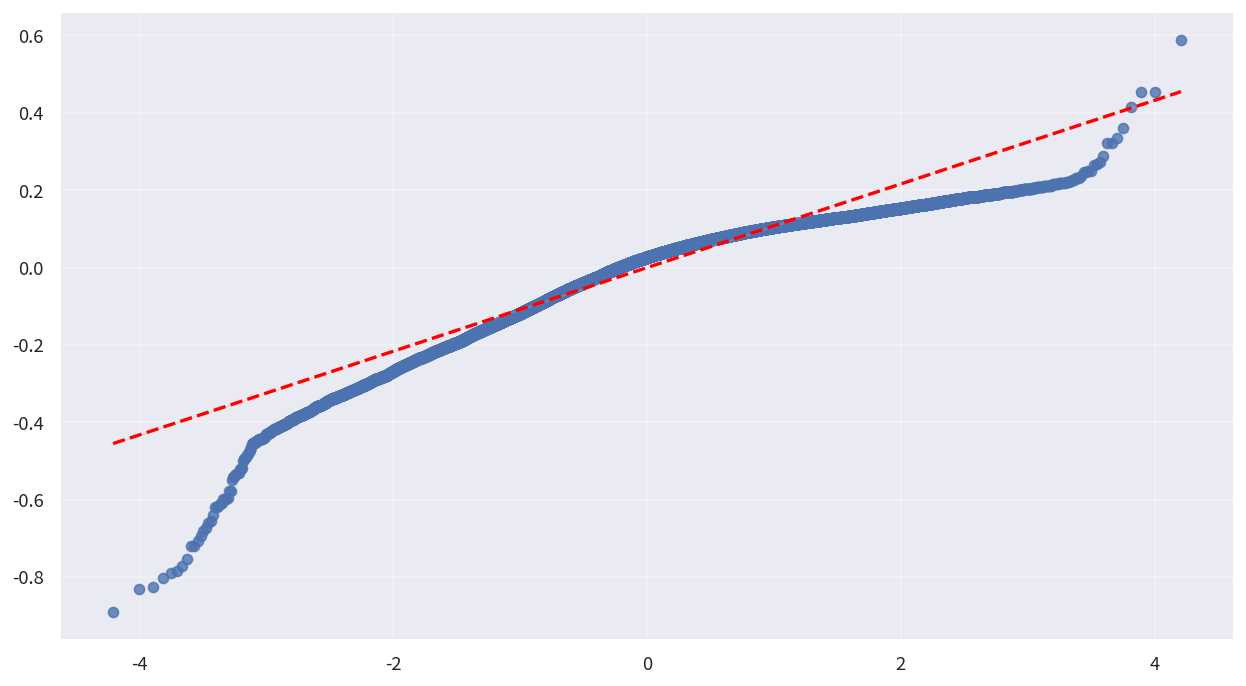

In [73]:
(x, y), _ = probplot(fit.resid)

# 1) 그래프 초기화
width_px  = 1280              # 그래프 가로 크기
height_px = 720               # 그래프 세로 크기
rows = 1                      # 그래프 행 수
cols = 1                      # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
    "color": "red",           # 점선 색상
    "linestyle": "--",        # 점선 스타일
    "linewidth": 2            # 점선 두께
})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)      # 배경 격자 표시

# 4) 출력
plt.tight_layout()            # 여백제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


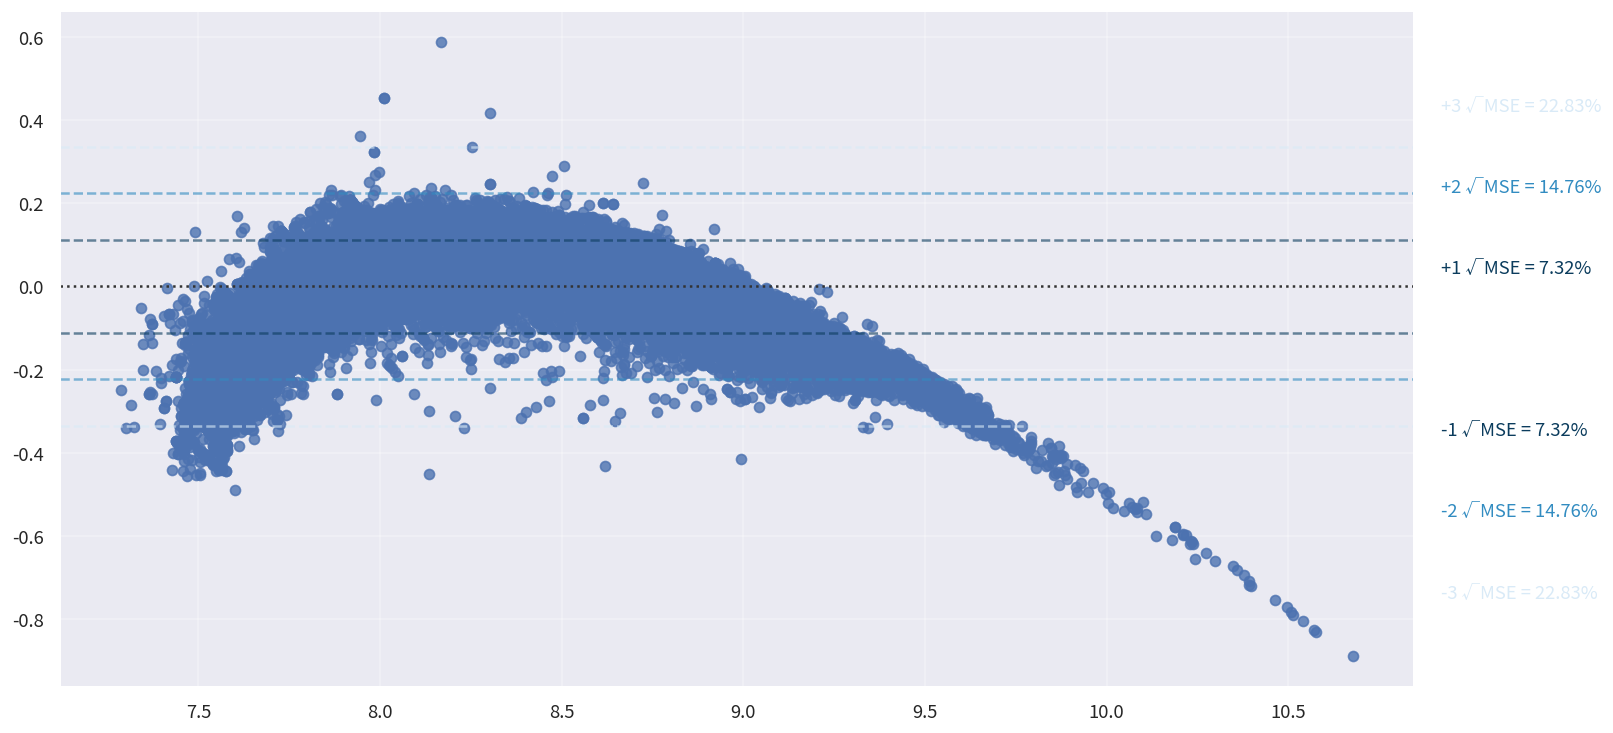

In [74]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid          # 잔차

r1 = r[(r > -mse_sq) & (r < mse_sq)].count() / r.count() * 100
r2 = r[(r > -2*mse_sq) & (r < 2*mse_sq)].count() / r.count() * 100
r3 = r[(r > -3*mse_sq) & (r < 3*mse_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

# 1) 그래프 초기화
width_px  = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)

# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)

# 3) 꾸미기
ax.grid(True, alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1

    # 윗방향 ±k√MSE 위치
    y_pos = k * mse_root

    ax.axhline(y=y_pos,  color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

# 5) 출력
plt.show()
plt.close()
